# mlp

> Implementation of mlp model using Pytorch

In [ ]:
#| default_exp makemore.mlp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from minion.makemore.bigram import stoi, itos
import math
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [ ]:
%matplotlib inline

## Motivations 

- Classical bigram model based on count is okay for bigram -2 characters
- However as we increase context windows, it quickly become out of hand
    - P(1 char|Given 1 prev char) -> 27 rows in Prob-table
    - P(1 char|Given 2 prev char) -> 27*27 = 729 rows in Prob-table
    - P(1 char|Given 3 prev char) -> 27 * 27 * 27 = 19683 ~ 20K rows in Prob-table or 20K possibilities of context

- Solution : Yoshua Bengio - Neural probabilistic language model
    - Word level language model (17K words, feature vector=30 - embedding--> Every word is embedded into 30 dimensional space). With 17K words, this space is very crowded - lot of points for 30 dimensional space
    - We will randomly initialize feature vectors per word
    - Then tune embeddings of the word using back propogation. During the course of training we can imagine that the words will be moving around in this space.
    - Intuition - words with very similar meanings or are synonyms of each other may end up in very similar part of this space. Words that mean very different things may go somewhere else in the space.

    Modelling approach
    - MLP to predict the next word given the previous word
    - To train the network weights - maximization of log likelihood.
    - 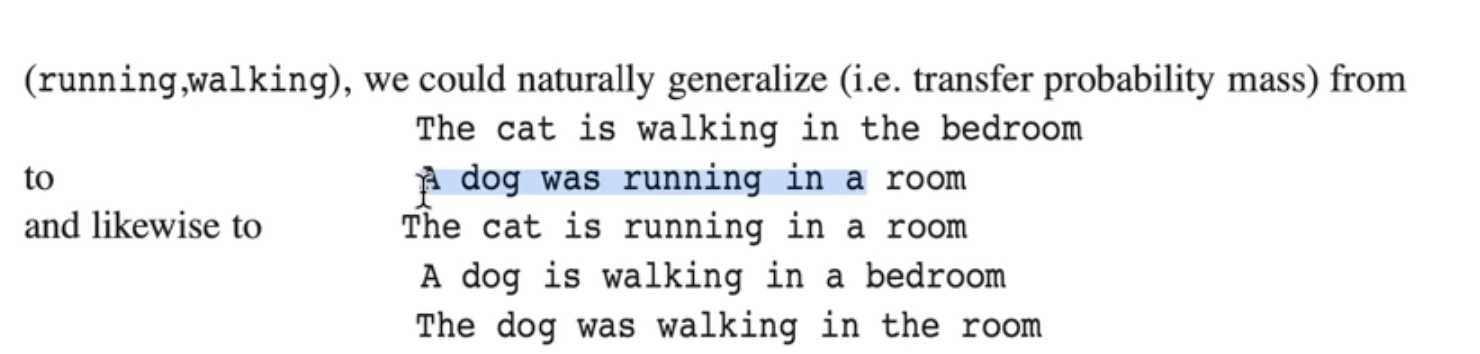
    - A and The in similar space
    - "A dog was running in a room" - never encountered in training set --> u are out of distribution
    - Probabilistic approach allows u to get around it --> May have seem similar sentences in training , "A" and "The" may seem to be frequently interchangable and therefore, may occupy similar space ["Cats" and "Dogs" are animal and they cooccur in very similar context]
    - Embedding helps in overcoming limitations and transfer knowledge through that way which helps in generalizing better
    - 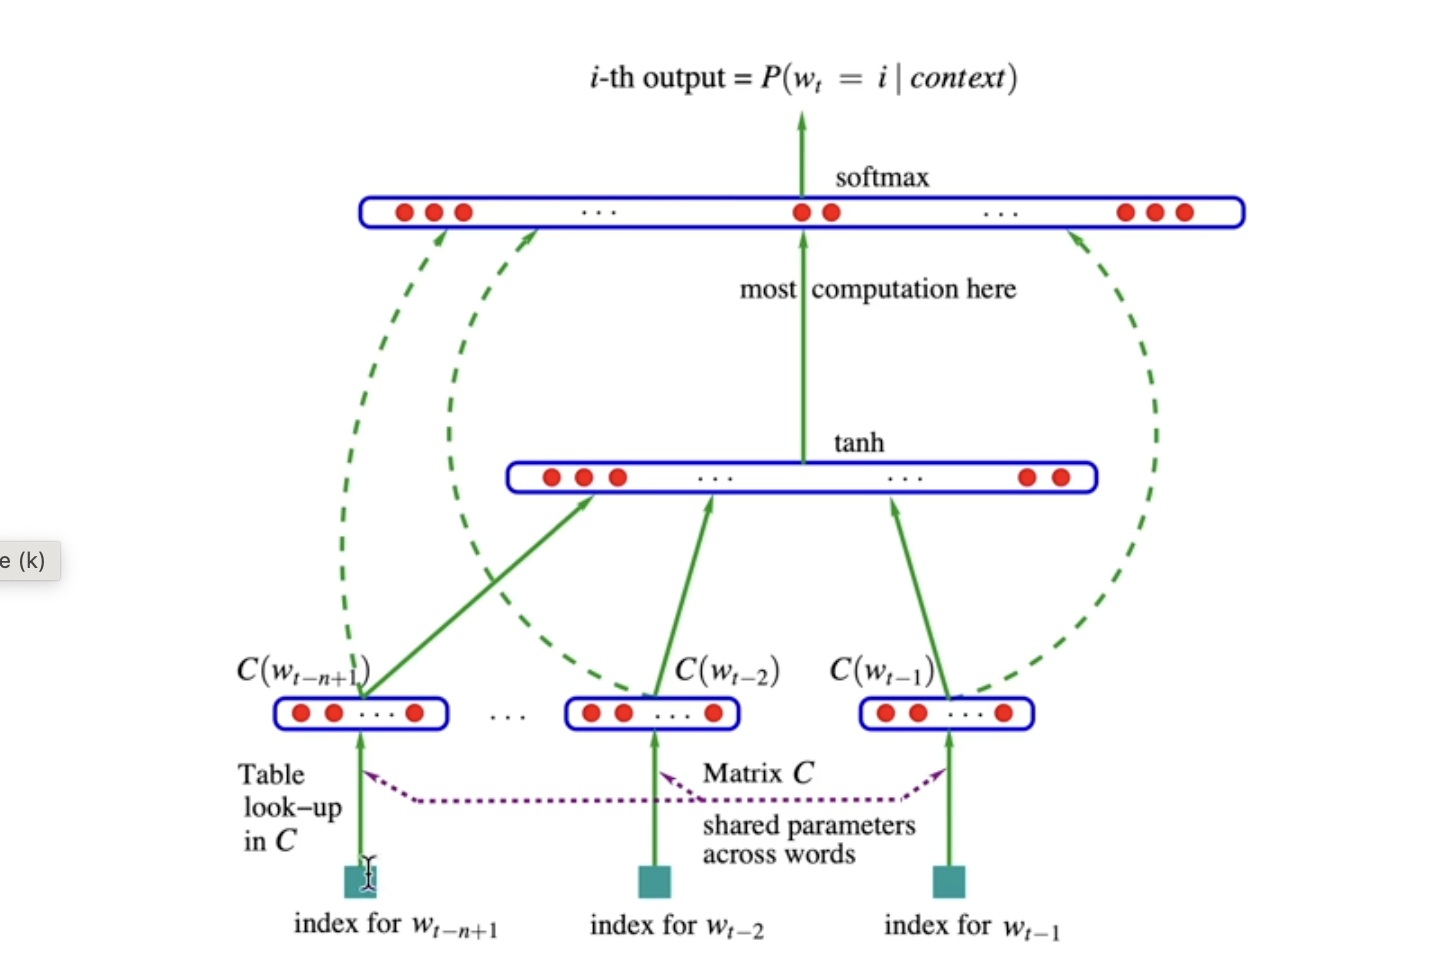
      - Matrix C is shared across the parameters/ words
      - Size of hidden layer is hyperparameter - this can be as large or as small. We will vary sizes and evalate how they work.
      - Output layer is with the softmax layer. --> 17K neurons- 17K logits -> softmax fully connected to all parameter in hidden layersoutput parameters
      - Parameters 
        - Weights and biases of output layer
        - Weights and biases of hidden layer
        - Look up table C [ How is this lookup table implemented??]


## Read the dataset

In [ ]:
words = open("../data/names.txt", 'r').read().split(); words[:5]
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [ ]:
s2i = stoi(words, start_str=".", end_str=".")
i2s = itos(s2i)
display(s2i)
display(i2s)

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
#| exports
def build_XY(words, s2i, block_size, str_term=".", verbose=False):
    X, Y = [], []
    for w in words:
        context = [s2i[str_term]]*block_size  # We need numerical embedding for each character 0 is for "."
        for ch in w + str_term:
            if verbose: 
                i2s = itos(s2i)
                print("".join([i2s[i] for i in context]),"-->", ch)
            X.append(context)
            Y.append(s2i[ch])
            context = context[1:] + [s2i[ch]]
    return torch.tensor(X), torch.tensor(Y)

In [ ]:
X, Y = build_XY(words[:2], s2i, block_size=5, verbose=True)
X, Y

..... --> e
....e --> m
...em --> m
..emm --> a
.emma --> .
..... --> o
....o --> l
...ol --> i
..oli --> v
.oliv --> i
olivi --> a
livia --> .


(tensor([[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  5],
         [ 0,  0,  0,  5, 13],
         [ 0,  0,  5, 13, 13],
         [ 0,  5, 13, 13,  1],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 15],
         [ 0,  0,  0, 15, 12],
         [ 0,  0, 15, 12,  9],
         [ 0, 15, 12,  9, 22],
         [15, 12,  9, 22,  9],
         [12,  9, 22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [ ]:
X, Y = build_XY(words[:2], s2i, block_size=3, verbose=True)
X, Y

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [ ]:
X, Y = build_XY(words, s2i, block_size=3)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
X, Y = build_XY(words[:5], s2i, block_size=3, verbose=True)
X.shape, X.dtype, Y.shape, Y.dtype

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Implementing Neural Network Step by Step

### Building embedding lookup table C

- 27 character and we need to embed them in lower dimensional space. 
- In paper they crammed 17K words in lower dimensional space (30)
- 27 characters with 2 dimensional space

In [ ]:
C = torch.randn((len(s2i),2), generator=torch.Generator().manual_seed(2147483647)); C.shape

torch.Size([27, 2])

In [ ]:
C[5]

tensor([-0.4713,  0.7868])

In [ ]:
a = F.one_hot(torch.tensor(5), num_classes=len(s2i)) 

a.float()@C

tensor([-0.4713,  0.7868])

- If we take one_hot vector and multiply by `C`
- Embedding of integer can be thought of as 
  - Indexing integer in a look up table `C`
  - Also we can think of this piece as first layer of NN- No activation-Weight matrix in C. Simply a lookup

Now looking up a value for a character in C is simply looking up an index.

In [ ]:
C[5]

tensor([-0.4713,  0.7868])

We can also do one-hot encoding of our charactar array and then provide one - hot vector and multiply by C which will pluck / lookup right weight for corresponding character

In [ ]:
c5 = F.one_hot(torch.tensor(5), num_classes=len(s2i)).float() # One hot vector for 5th character + put input as tensor of float not int or tensor[int]
c5@C


tensor([-0.4713,  0.7868])

Above implies we can think of embedding in 2 ways

- Integer indexing into a look up table `C`
- Or First layer of bigger neural network
    - This embedding layer have neuron that have no non-linearity/ activation - linear 
    - And their weight matrix is `C`
    - We are just encoding the character to one-hot and feeding into NN and first layers basically embeds them
    - We index them because it's much much faster

### Sidenote on Pytorch indexing 

#### Index on int

In [ ]:
C[5]

tensor([-0.4713,  0.7868])

#### Index on list

In [ ]:
C[[5,6,7]]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

#### Index on tensors

In [ ]:
C[torch.tensor([5,6,7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

In [ ]:
C[torch.tensor([5,6,7, 7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.3729,  2.9334]])

#### Index with multidimensional tensor of integers

In [ ]:
display(C[X].shape)
display(C[X][:5])
display(C[X][:5].shape)

torch.Size([32, 3, 2])

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]]])

torch.Size([5, 3, 2])

### Implementing embedding lookup table

In [ ]:
C[X]

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.0725,  0.7276]],

        [[ 1.5674, -0.2373],
         [-1.0725,  0.7276],
         [-0.0707,  2.4968]],

        [[-1.0725,  0.7276],
         [-0.0707,  2.4968],
         [ 0.6772, -0.8404]],

        [[-0.0707,  2.4968],
         [ 0.6772, -0.8404],
         [-0.1158, -1.2078]],

        [[ 0.6772, -0.8404],
         [-0.1158, -1.2078],
         [ 0.6772, -0.8404]],

        [[-0.1158, -1

In [ ]:
X.shape, C[X].shape

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

We have a character input of 32 by 3 . For each of them we have gotten an embedding vector

In [ ]:
display(X[13,2])
C[X][13, 2]

tensor(1)

tensor([-0.0274, -1.1008])

In [ ]:
C[1]

tensor([-0.0274, -1.1008])

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### Implementing the hidden layer + internals of torch.Tensor: storage, views

- We are going to stack 3 characters . So number of features for hidden layers are 6 (3*2)
- We can choose any number of neurons for hidden layer. Let's start by choosing 100 neurons
- Size of hidden layer (features, neurons)


In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

What we want to do emb@W1+b1?

- Above won't work 
- emb size is 32*3*2
- W1 size is 6*100
- We somehow need to concatenate multiple embeddings into single tensor array


In [ ]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969,

In [ ]:
emb.shape

emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # Not scalable with larger context

torch.Size([32, 6])

In [ ]:
a = torch.unbind(emb, 1)
len(a); a

(tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.0725,  0.7276],
         [-0.0707,  2.4968],
         [ 0.6772, -0.8404],
         [-0.1158, -1.2078],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 0.6772, -0.8404],
         [ 0.1476, -1.0006],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296],
         [-0.4713,  0.7868],
         [-0.0707,  2.4968],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 0.1476, -1.0006],
         [-1.0725,  0.7276],
         [ 0.0511,  1.3095],
         [ 1.5618, -1.6261]]),
 tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [ ]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [ ]:
a.view(2, 9)
a.view(9,2)
a.view(3,3,2) # Extremely efficient 

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [ ]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

:::callout-important

- In pytorch, tensor is always stored as a 1 dimensional vector ( represented in computer memory)
- When calling view - internals of tensors - storage offsets, strides and shapes are being manipulated
- Calling view is extremely efficient . No memory is being changed 
- Concatenation is much less efficient - New memory is being created when u use concatenation(Whole new tensor with a whole new storage). No way of concatenating the tensor by manipulating the view attribute
- Tensor shape is just a logical view of physical memory 
    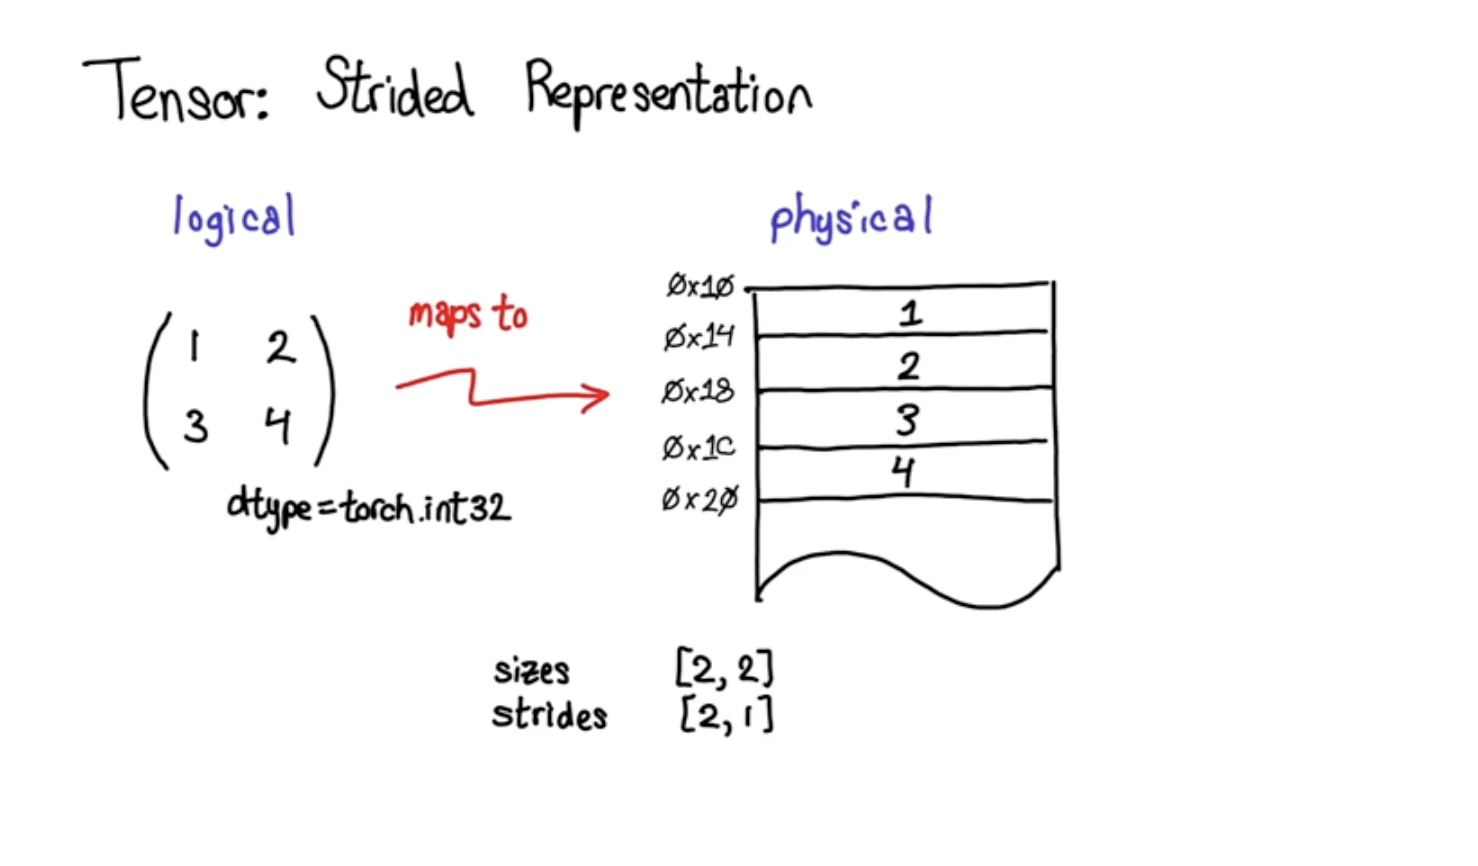
- More on Pytorch internals is [here](http://blog.ezyang.com/2019/05/pytorch-internals/)


:::

In [ ]:
emb.shape

emb[1]

tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.4713,  0.7868]])

In [ ]:
emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [ ]:
emb.view(-1, 6)[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [ ]:
emb.view(emb.shape[0], -1)[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [ ]:
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2])@W1 + b1)
h

tensor([[ 0.9696, -0.0761,  0.0969,  ...,  0.8818, -0.9987,  0.9760],
        [-0.9849, -0.7707, -0.9131,  ...,  0.9966, -0.9847,  0.9979],
        [ 0.9986,  0.9569, -0.3098,  ..., -0.9844, -0.5528, -0.0351],
        ...,
        [ 0.9896,  0.9411, -0.8544,  ...,  0.9877, -0.9991, -0.9401],
        [ 1.0000, -0.4195,  0.4700,  ...,  0.9998, -0.9997,  0.9730],
        [-0.1685,  0.9893,  0.9984,  ...,  0.5667, -0.9995,  0.9994]])

### Final layer


In [ ]:

W2 = torch.randn((100, len(s2i)))
b2 = torch.randn(len(s2i))

In [ ]:
W2.shape, W2.nelement()

(torch.Size([100, 27]), 2700)

In [ ]:
logits = h@W2+b2; logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True); prob.shape

torch.Size([32, 27])

In [ ]:
prob.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

## Refactoring 

### Model Class

In [ ]:
#| exports
class Model(object):
    def __init__(self, vocab_sz, blck_sz=3, emb_sz=2, hidden_units=100, g=torch.Generator().manual_seed(2147483647)) -> None:
        self.C = torch.randn((vocab_sz,emb_sz), generator=g, requires_grad=True)
        self.W1 = torch.randn((blck_sz*emb_sz, hidden_units), generator=g, requires_grad=True)
        self.b1 = torch.randn(hidden_units, generator=g, requires_grad=True)
        self.W2 = torch.randn((hidden_units, vocab_sz), generator=g, requires_grad=True)
        self.b2 = torch.randn(vocab_sz, generator=g, requires_grad=True)
        self.blck_sz = blck_sz
        self.emb_sz = emb_sz
        self.hidden_units = hidden_units

    def __call__(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2])@self.W1 + self.b1)
        logits = h@self.W2 + self.b2
        return logits
    
    def parameters(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]

    def num_params(self):
        return sum(p.nelement() for p in self.parameters())
    
    def zero_grad(self):
        for p in self.parameters(): 
            # print(p.shape, p.data, p.grad)
            p.grad = None
    

In [ ]:
F.cross_entropy??

Signature:
F.cross_entropy(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> torch.Tensor
Source:   
def cross_entropy(
    input: Tensor,
    target: Tensor,
    weight: Optional[Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
    label_smoothing: float = 0.0,
) -> Tensor:
    r"""This criterion computes the cross entropy loss between input logits and target.

    See :class:`~torch.nn.CrossEntropyLoss` for details.

    Args:
        input (Tensor) : Predicted unnormalized logits;
            see Shape section below for supported shapes.
        target (Tensor) : Ground truth class indices or class probabilities;
            see Shape section below for supported shape

### Model loss

In [ ]:
#| exports
def softmax(inputs, dim=1):
    c  = -torch.max(inputs)
    counts = (inputs+c).exp()
    probs = counts/ counts.sum(dim=dim, keepdim=True)
    return probs

In [ ]:
inputs = torch.tensor([[-1, 0, 1]]).float()
softmax(inputs)

tensor([[0.0900, 0.2447, 0.6652]])

In [ ]:
inputs.shape

torch.Size([1, 3])

In [ ]:
F.softmax(inputs, dim=1)

tensor([[0.0900, 0.2447, 0.6652]])

In [ ]:
#| exports
def nll(inputs,  #Takes logits
        target  #Takes y
        ): 
    # counts = inputs.exp()
    # c  = -torch.max(inputs)
    # counts = (inputs+c).exp()
    # probs = counts/ counts.sum(dim=1, keepdim=True)
    probs = softmax(inputs, dim=1)
    loss = -probs[torch.arange(len(target)), target].log().mean()
    return loss


### Forward Pass and Update

In [ ]:
X, Y = build_XY(words[:5], s2i, block_size=3); X.shape, Y.shape
lr = 0.01
model = Model(len(s2i))

# Forward Pass
logits = model(X); logits.shape 
# loss = nll(logits, Y)
loss = F.cross_entropy(logits, Y)
loss2 = nll(logits, Y)

# Backward Pass
model.zero_grad()
loss.backward(); loss, loss2

# # Update
# for p in model.parameters():
#     p.data -= lr*p.grad

# model.parameters()[0].grad

# model.parameters()[1].grad
# len(model.parameters())

for p in model.parameters():
    p.data -=lr*p.grad

### Minibatch Construct

In [ ]:
# torch.randint()
display(X.shape)

torch.randint(low=0, high=10, size=(3,))

torch.Size([32, 3])

tensor([0, 6, 8])

In [ ]:
batch_size = 32
ix = torch.randint(low=0, high=X.shape[0], size=(batch_size,))

X[ix].shape

torch.Size([32, 3])

In [ ]:
a = model.C.detach().numpy(); a.shape

(27, 2)

<matplotlib.collections.PathCollection>

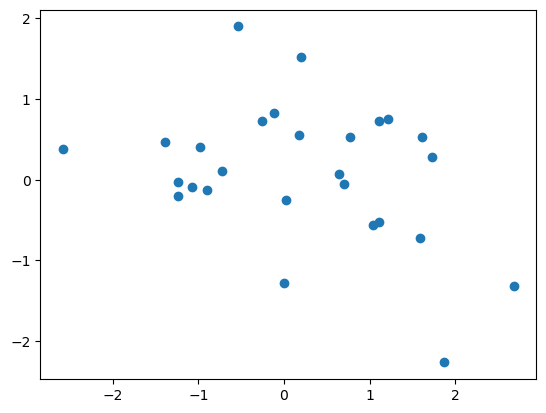

In [ ]:
plt.scatter(a[:,0], a[:,1])

In [619]:
#| exports
def plot_embeddings(model, s2i, emb_model=None, cluster_model = None):
    i2s = itos(s2i)
    plt.figure(figsize=(8,8))
    
    c = model.C.detach().numpy()
    if not emb_model: a = c
    else: a = emb_model.fit_transform(c)
    if not cluster_model: plt.scatter(a[:,0], a[:,1], s=200)
    else: 
        label = cluster_model.fit_predict(c)
        plt.scatter(a[:,0], a[:,1], s=200, c=label)
    for i in range(a.shape[0]):
        # plt.text()
        plt.text(a[i,0], a[i,1], i2s[i], ha='center', va='center', color='white')
    plt.grid()

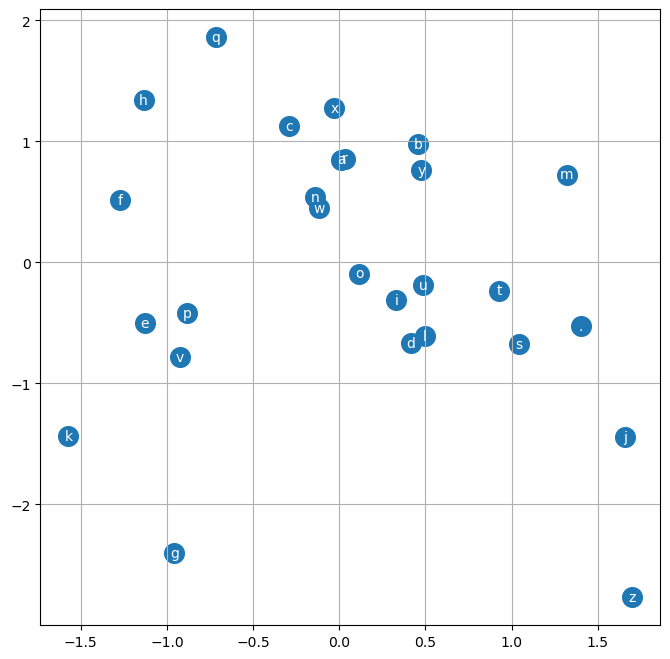

In [620]:
model = Model(len(s2i))
plot_embeddings(model, s2i)

/opt/homebrew/Caskroom/miniforge/base/envs/aiking/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


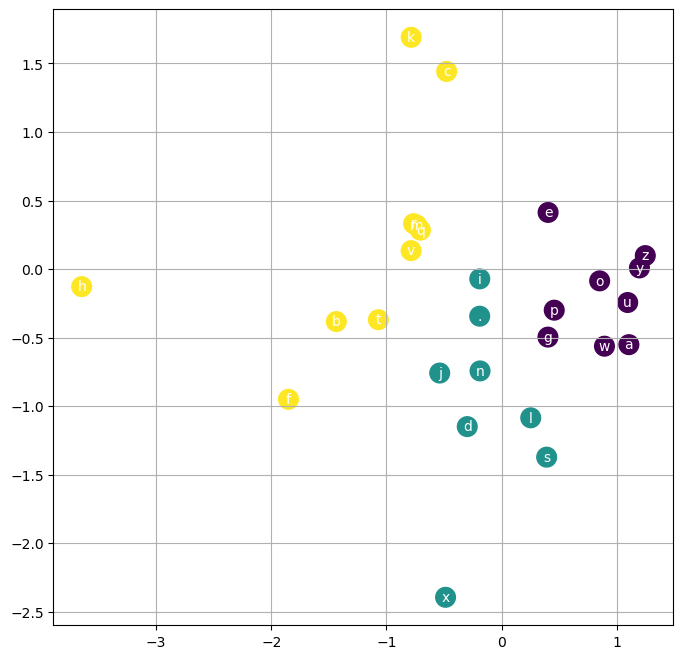

In [621]:
model = Model(len(s2i))
plot_embeddings(model, s2i, cluster_model=KMeans(n_clusters=3))

### Training Function

In [ ]:
#| exports
def train(model, X, Y, lr=0.1, epochs=1000, verbose=False, batch_sz=None, loss_fn=F.cross_entropy, tracker = None):
    

    for i in range(epochs):
    
        #minibatch construct
        inputs = X
        target = Y
        if batch_sz:
            ix = torch.randint(low=0, high=X.shape[0], size=(batch_sz,))
            inputs = X[ix]
            target = Y[ix]
        
        # Forward Pass
        logits = model(inputs); logits.shape 
        # loss = nll(logits, Y)
        loss = loss_fn(logits, target)
        # loss2 = nll(logits, Y)

        # Backward Pass
        model.zero_grad()
        loss.backward(); 
        if i%100 == 0 and verbose: print(i, loss)
        if i == epochs-1: print(i, loss)


        ## Update / Gradient
        lri = next(lr).item() if hasattr(lr, "__next__") else lr
        for p in model.parameters():
            p.data -=lri*p.grad

        if tracker is not None:
            tracker.get('lr', []).append(lri)
            tracker.get('loss', []).append(loss.item())
            tracker.get('batch_sz', []).append(batch_sz)
            tracker.get('block_sz', []).append(X.shape[1])
            tracker.get('emb_sz', []).append(model.C.shape[1])
            tracker.get('hidden_units', []).append(model.b1.shape[0])
    return model


In [ ]:
X.shape[1]

3

In [ ]:
X, Y = build_XY(words, s2i, block_size=3); X.shape, Y.shape
model = Model(len(s2i))

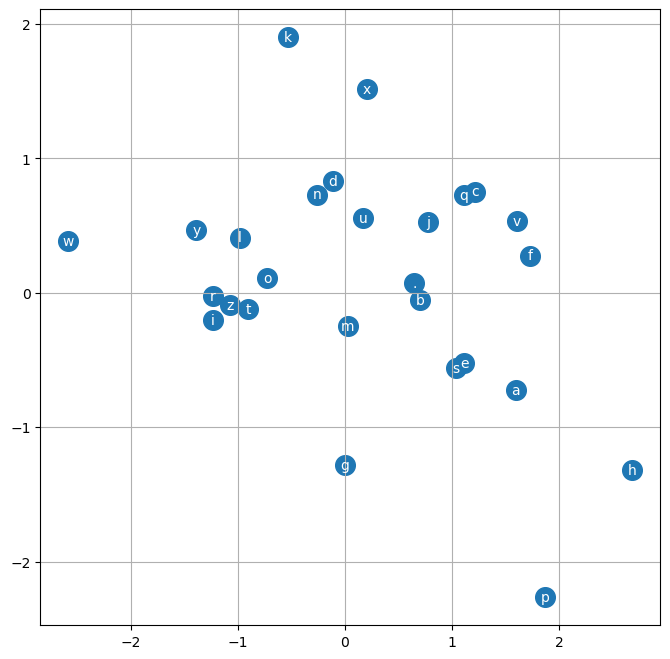

In [ ]:
plot_embeddings(model, s2i)

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }

In [ ]:
model = train(model, X, Y,  epochs=400, verbose=True, tracker=tracker, batch_sz=None)

0 tensor(16.1822, grad_fn=<NllLossBackward0>)


100 tensor(3.1182, grad_fn=<NllLossBackward0>)
200 tensor(2.7789, grad_fn=<NllLossBackward0>)
300 tensor(2.6775, grad_fn=<NllLossBackward0>)
399 tensor(2.6257, grad_fn=<NllLossBackward0>)


In [ ]:
tracker is not None

True

In [ ]:
tracker.keys()

dict_keys(['lr', 'batch_sz', 'loss', 'block_sz', 'emb_sz', 'hidden_units'])

[<matplotlib.lines.Line2D>]

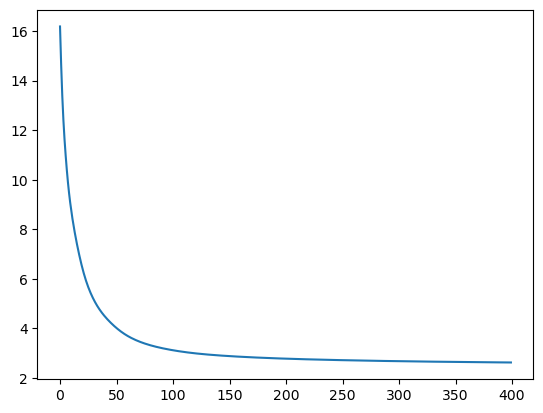

In [ ]:
plt.plot(tracker['loss'])

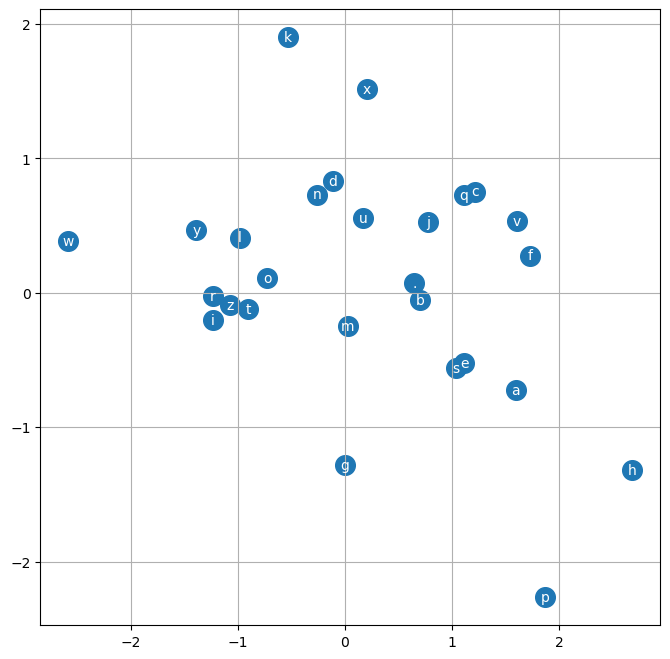

In [ ]:
plot_embeddings(model, s2i)

### Training with minibatch

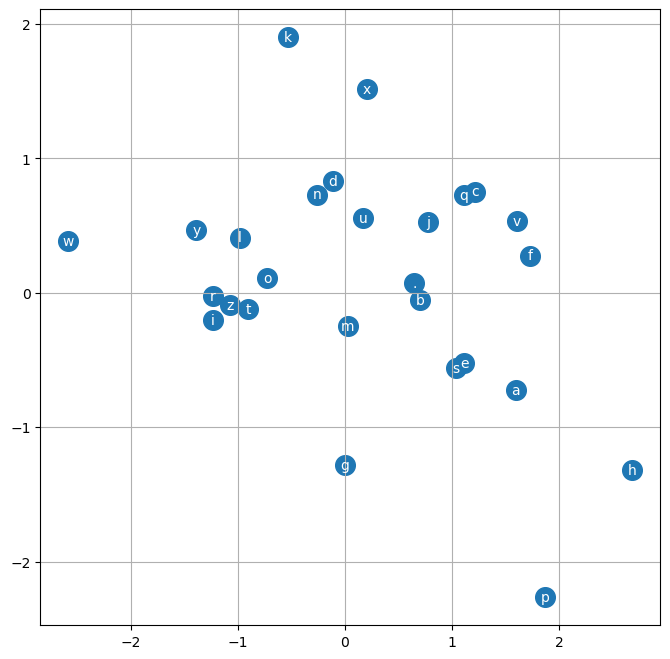

In [ ]:
X, Y = build_XY(words, s2i, block_size=3); X.shape, Y.shape
model = Model(len(s2i))
plot_embeddings(model, s2i)

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }


In [ ]:
model = train(model, X, Y,  epochs=2000, verbose=True, tracker=tracker, batch_sz=32); model

0 tensor(17.3736, grad_fn=<NllLossBackward0>)
100 tensor(3.5120, grad_fn=<NllLossBackward0>)
200 tensor(3.2923, grad_fn=<NllLossBackward0>)
300 tensor(2.5880, grad_fn=<NllLossBackward0>)
400 tensor(2.7083, grad_fn=<NllLossBackward0>)
500 tensor(2.8158, grad_fn=<NllLossBackward0>)
600 tensor(2.8590, grad_fn=<NllLossBackward0>)
700 tensor(2.7595, grad_fn=<NllLossBackward0>)
800 tensor(2.6768, grad_fn=<NllLossBackward0>)
900 tensor(2.9124, grad_fn=<NllLossBackward0>)
1000 tensor(2.6611, grad_fn=<NllLossBackward0>)
1100 tensor(2.2173, grad_fn=<NllLossBackward0>)
1200 tensor(2.2574, grad_fn=<NllLossBackward0>)
1300 tensor(2.3949, grad_fn=<NllLossBackward0>)
1400 tensor(2.7110, grad_fn=<NllLossBackward0>)
1500 tensor(2.9206, grad_fn=<NllLossBackward0>)
1600 tensor(2.5418, grad_fn=<NllLossBackward0>)
1700 tensor(2.5544, grad_fn=<NllLossBackward0>)
1800 tensor(2.8429, grad_fn=<NllLossBackward0>)
1900 tensor(2.2609, grad_fn=<NllLossBackward0>)
1999 tensor(2.5404, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
model.num_params() # Number of parameter in the model

3481

[<matplotlib.lines.Line2D>]

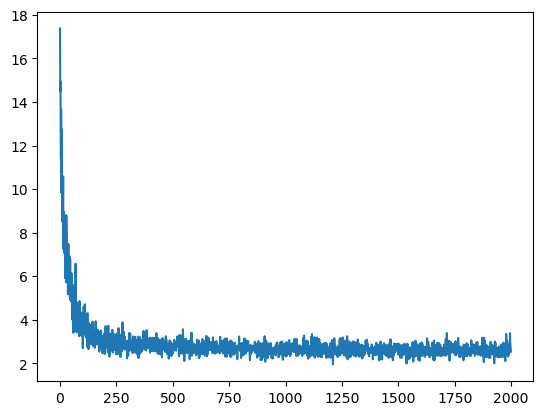

In [ ]:
plt.plot(tracker['loss'])

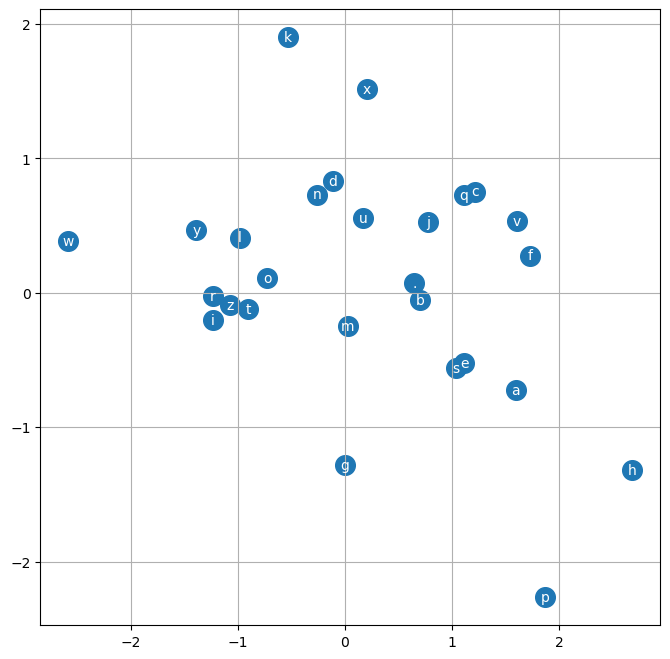

In [ ]:
plot_embeddings(model, s2i)

### Implementing Word Generator

In [ ]:
# X[ix]
ix = 0
# model.C[X[ix]]
X[ix]

# model(torch.tensor([0,0,0]))

emb = model.C[torch.tensor([0,0,0])]
# emb.shape[0], emb.shape[1], emb.shape[2]
emb.shape

torch.Size([3, 2])

In [ ]:
X[ix]
X.shape

torch.Size([228146, 3])

In [ ]:
ix = 0
g=torch.Generator().manual_seed(2147483647)

n_samples = 20
gen_words = []

In [ ]:
for i in range(n_samples):
    ix = 0
    gen_word = ""
    inp = [ix]*model.blck_sz
    
    while True:
        logits = model(torch.tensor([inp]))
        counts = logits.exp() # equivalent N
        probs = counts/ counts.sum(1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        
        inp.pop(0)
        inp.append(ix)
        if ix == 0: break
        else: gen_word +=i2s[ix]
    gen_words.append(gen_word)
    
# probs
ix


0

In [ ]:
F

<module 'torch.nn.functional' from '/opt/homebrew/Caskroom/miniforge/base/envs/aiking/lib/python3.9/site-packages/torch/nn/functional.py'>

In [ ]:
inp, words

([18, 21, 0],
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn',
  'abigail',
  'emily',
  'elizabeth',
  'mila',
  'ella',
  'avery',
  'sofia',
  'camila',
  'aria',
  'scarlett',
  'victoria',
  'madison',
  'luna',
  'grace',
  'chloe',
  'penelope',
  'layla',
  'riley',
  'zoey',
  'nora',
  'lily',
  'eleanor',
  'hannah',
  'lillian',
  'addison',
  'aubrey',
  'ellie',
  'stella',
  'natalie',
  'zoe',
  'leah',
  'hazel',
  'violet',
  'aurora',
  'savannah',
  'audrey',
  'brooklyn',
  'bella',
  'claire',
  'skylar',
  'lucy',
  'paisley',
  'everly',
  'anna',
  'caroline',
  'nova',
  'genesis',
  'emilia',
  'kennedy',
  'samantha',
  'maya',
  'willow',
  'kinsley',
  'naomi',
  'aaliyah',
  'elena',
  'sarah',
  'ariana',
  'allison',
  'gabriella',
  'alice',
  'madelyn',
  'cora',
  'ruby',
  'eva',
  'serenity',
  'autumn',
  'adeline',
  'hailey',
  'gianna',
  'valentina',
  'isla',
  'eliana',
  'q

In [ ]:
#| exports
def gen_word_nn(model, i2s, n_samples=20, g=torch.Generator().manual_seed(2147483647), logit2prob=F.softmax):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        inp = [ix]*model.blck_sz
        
        while True:
            logits = model(torch.tensor([inp]))
            # counts = logits.exp() # equivalent N
            # probs = counts/ counts.sum(1, keepdims=True)

            probs = logit2prob(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            
            inp.pop(0)
            inp.append(ix)
            if ix == 0: break
            else: gen_word +=i2s[ix]
        gen_words.append(gen_word)
    return gen_words

In [ ]:
gen_word_nn(model, i2s)

['tex',
 'maloallurarlen',
 'tynn',
 'ralimittarnrllayn',
 'kanda',
 'raciynu',
 'jarhrygotei',
 'molielltiu',
 'jerteda',
 'kareynm',
 'sadlu',
 'nkaviyn',
 'rytlsp',
 'hulinnnvtarlysu',
 'jsdr',
 'ban',
 'jlhpynw',
 'iranl',
 'raldynleez',
 'myderu']

## Hyperparameter tuning

### How do we determine the learning rate and gain confidence that we are stepping the right speed? 

Typical steps in learning rate optimization may include

- Finding the range with lower limit of `lr` where loss doesn't change much and higher limit where loss completely explodes
- Finding the more appropriate range of learning rate by choosing an exponentiation scheme and running the training for few epochs
- Running training for lots of epochs on choosen `lr` ( We should continue to do it till learning rate keeps decreasing signficantly)
- Decreasing `lr` by a factor of 10 and continue to train further to get most optimized learning rate.

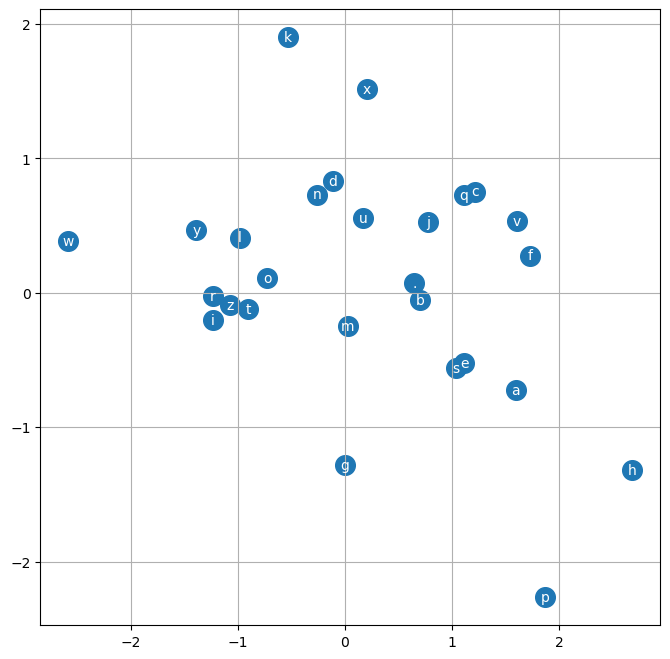

In [ ]:
X, Y = build_XY(words, s2i, block_size=3); X.shape, Y.shape
model = Model(len(s2i))
plot_embeddings(model, s2i)

In [ ]:
F.cross_entropy(model(X), Y) # Initial loss without any optimization

tensor(15.4238, grad_fn=<NllLossBackward0>)

In [ ]:
train(model, X, Y, lr=0.0001, epochs=1000, batch_sz=32, verbose=True)

0 tensor(18.4698, grad_fn=<NllLossBackward0>)
100 tensor(17.9110, grad_fn=<NllLossBackward0>)
200 tensor(16.4214, grad_fn=<NllLossBackward0>)
300 tensor(14.0824, grad_fn=<NllLossBackward0>)
400 tensor(13.0391, grad_fn=<NllLossBackward0>)
500 tensor(16.9305, grad_fn=<NllLossBackward0>)
600 tensor(16.5712, grad_fn=<NllLossBackward0>)
700 tensor(15.7921, grad_fn=<NllLossBackward0>)
800 tensor(12.6845, grad_fn=<NllLossBackward0>)
900 tensor(12.2210, grad_fn=<NllLossBackward0>)
999 tensor(17.0267, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
train(model, X, Y, lr=1, epochs=1000, batch_sz=32, verbose=True)

0 tensor(13.1564, grad_fn=<NllLossBackward0>)
100 tensor(8.6120, grad_fn=<NllLossBackward0>)
200 tensor(4.7459, grad_fn=<NllLossBackward0>)
300 tensor(5.8324, grad_fn=<NllLossBackward0>)
400 tensor(5.4408, grad_fn=<NllLossBackward0>)
500 tensor(5.1435, grad_fn=<NllLossBackward0>)
600 tensor(4.8215, grad_fn=<NllLossBackward0>)
700 tensor(4.8802, grad_fn=<NllLossBackward0>)
800 tensor(3.4567, grad_fn=<NllLossBackward0>)
900 tensor(3.2230, grad_fn=<NllLossBackward0>)
999 tensor(3.2829, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
train(model, X, Y, lr=10, epochs=1000, batch_sz=32, verbose=True)

0 tensor(2.8849, grad_fn=<NllLossBackward0>)
100 tensor(83.2786, grad_fn=<NllLossBackward0>)
200 tensor(93.7002, grad_fn=<NllLossBackward0>)
300 tensor(60.7121, grad_fn=<NllLossBackward0>)
400 tensor(34.8946, grad_fn=<NllLossBackward0>)
500 tensor(79.4215, grad_fn=<NllLossBackward0>)
600 tensor(34.4919, grad_fn=<NllLossBackward0>)
700 tensor(54.7734, grad_fn=<NllLossBackward0>)
800 tensor(58.9727, grad_fn=<NllLossBackward0>)
900 tensor(54.2846, grad_fn=<NllLossBackward0>)
999 tensor(76.2547, grad_fn=<NllLossBackward0>)


<__main__.Model>

This indicates learning rate should be choosen between 0 and 1

In [ ]:
#| exports
def lr_scheduler(low=-3, upper=0, steps=1000):
    yield from 10**torch.linspace(low, upper, steps)

# for i in lr_scheduler():
#     print(i)
    # break

# torch.linspace(-3, 0, 1000)

# for i in torch.pow(10, torch.linspace(-3, 0, 1000)):
#     print(i)
# for i in torch.pow(10, torch.linspace(-3, 0, 1000)):
#     print(i.item())



In [ ]:
hasattr( lr_scheduler(), "__next__")

True

In [ ]:
next(lr_scheduler())

tensor(0.0010)

tensor(19.4207, grad_fn=<NllLossBackward0>)

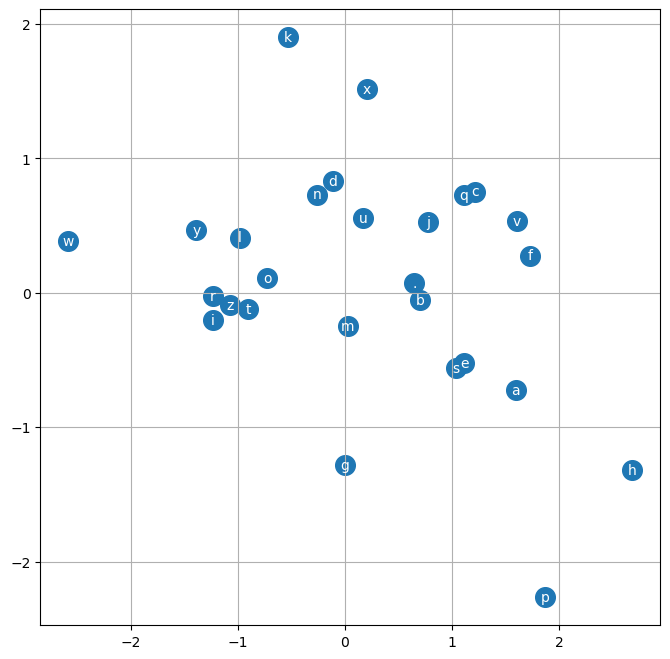

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i))
plot_embeddings(model, s2i); F.cross_entropy(model(X), Y) 

In [ ]:
train(model, X, Y, lr=lr_scheduler(steps=1000), epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(20.5248, grad_fn=<NllLossBackward0>)
100 tensor(17.5990, grad_fn=<NllLossBackward0>)
200 tensor(13.2811, grad_fn=<NllLossBackward0>)
300 tensor(7.4093, grad_fn=<NllLossBackward0>)
400 tensor(6.2343, grad_fn=<NllLossBackward0>)
500 tensor(3.3622, grad_fn=<NllLossBackward0>)
600 tensor(3.9428, grad_fn=<NllLossBackward0>)
700 tensor(3.1582, grad_fn=<NllLossBackward0>)
800 tensor(3.4537, grad_fn=<NllLossBackward0>)
900 tensor(6.5724, grad_fn=<NllLossBackward0>)
999 tensor(7.3060, grad_fn=<NllLossBackward0>)


<__main__.Model>

[<matplotlib.lines.Line2D>]

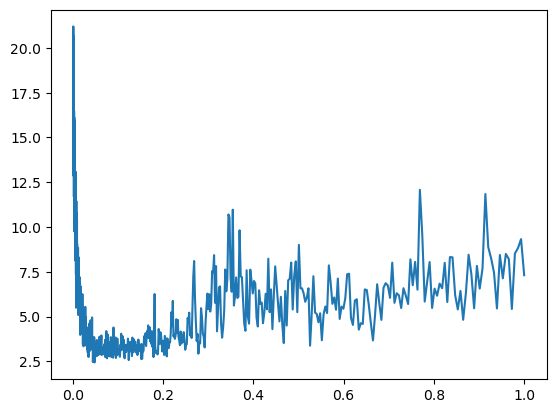

In [ ]:
plt.plot(tracker['lr'], tracker['loss'])
# tracker['lr']

In [ ]:
min_idx = torch.tensor(tracker['loss']).min(dim=0).indices.item()
tracker['lr'][min_idx]

0.04804869741201401

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
log_lrs[min_idx], lrs[min_idx]

(tensor(-3.0355), tensor(0.0480))

Text(tensor(-2.7320), tensor(2.1892), 'lr : 0.05, loss : 2.43')

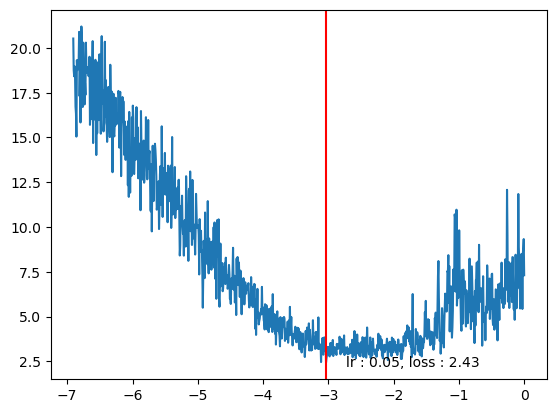

In [ ]:
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

In [ ]:
train(model, X, Y, lr=0.05, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(7.7239, grad_fn=<NllLossBackward0>)
100 tensor(3.4564, grad_fn=<NllLossBackward0>)
200 tensor(2.3491, grad_fn=<NllLossBackward0>)
300 tensor(2.6205, grad_fn=<NllLossBackward0>)
400 tensor(3.1440, grad_fn=<NllLossBackward0>)
500 tensor(2.7919, grad_fn=<NllLossBackward0>)
600 tensor(2.4809, grad_fn=<NllLossBackward0>)
700 tensor(2.8206, grad_fn=<NllLossBackward0>)
800 tensor(2.6108, grad_fn=<NllLossBackward0>)
900 tensor(2.8789, grad_fn=<NllLossBackward0>)
1000 tensor(2.2781, grad_fn=<NllLossBackward0>)
1100 tensor(2.3718, grad_fn=<NllLossBackward0>)
1200 tensor(3.1925, grad_fn=<NllLossBackward0>)
1300 tensor(2.6590, grad_fn=<NllLossBackward0>)
1400 tensor(2.4634, grad_fn=<NllLossBackward0>)
1500 tensor(2.5142, grad_fn=<NllLossBackward0>)
1600 tensor(2.6078, grad_fn=<NllLossBackward0>)
1700 tensor(2.4267, grad_fn=<NllLossBackward0>)


1800 tensor(2.3398, grad_fn=<NllLossBackward0>)
1900 tensor(2.1698, grad_fn=<NllLossBackward0>)
2000 tensor(2.4727, grad_fn=<NllLossBackward0>)
2100 tensor(2.6651, grad_fn=<NllLossBackward0>)
2200 tensor(2.8141, grad_fn=<NllLossBackward0>)
2300 tensor(2.6341, grad_fn=<NllLossBackward0>)
2400 tensor(2.4364, grad_fn=<NllLossBackward0>)
2500 tensor(2.5922, grad_fn=<NllLossBackward0>)
2600 tensor(2.5449, grad_fn=<NllLossBackward0>)
2700 tensor(2.6220, grad_fn=<NllLossBackward0>)
2800 tensor(2.1987, grad_fn=<NllLossBackward0>)
2900 tensor(2.3869, grad_fn=<NllLossBackward0>)
3000 tensor(2.3194, grad_fn=<NllLossBackward0>)
3100 tensor(2.1561, grad_fn=<NllLossBackward0>)
3200 tensor(2.2904, grad_fn=<NllLossBackward0>)
3300 tensor(2.7685, grad_fn=<NllLossBackward0>)
3400 tensor(2.4733, grad_fn=<NllLossBackward0>)
3500 tensor(2.3755, grad_fn=<NllLossBackward0>)
3600 tensor(2.3150, grad_fn=<NllLossBackward0>)
3700 tensor(2.2893, grad_fn=<NllLossBackward0>)
3800 tensor(2.1896, grad_fn=<NllLossBack

<__main__.Model>

In [ ]:
train(model, X, Y, lr=0.005, epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.4155, grad_fn=<NllLossBackward0>)
100 tensor(2.3920, grad_fn=<NllLossBackward0>)
200 tensor(2.2776, grad_fn=<NllLossBackward0>)
300 tensor(2.1948, grad_fn=<NllLossBackward0>)
400 tensor(2.7162, grad_fn=<NllLossBackward0>)
500 tensor(2.2897, grad_fn=<NllLossBackward0>)
600 tensor(2.2183, grad_fn=<NllLossBackward0>)
700 tensor(2.1047, grad_fn=<NllLossBackward0>)
800 tensor(2.0977, grad_fn=<NllLossBackward0>)
900 tensor(2.2447, grad_fn=<NllLossBackward0>)
999 tensor(2.4003, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
## Weight decay
train(model, X, Y, lr=0.0050, epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.2350, grad_fn=<NllLossBackward0>)
100 tensor(2.0883, grad_fn=<NllLossBackward0>)
200 tensor(2.5197, grad_fn=<NllLossBackward0>)
300 tensor(2.2276, grad_fn=<NllLossBackward0>)
400 tensor(2.6038, grad_fn=<NllLossBackward0>)
500 tensor(2.0107, grad_fn=<NllLossBackward0>)
600 tensor(2.3911, grad_fn=<NllLossBackward0>)
700 tensor(2.7271, grad_fn=<NllLossBackward0>)
800 tensor(2.7542, grad_fn=<NllLossBackward0>)
900 tensor(2.4474, grad_fn=<NllLossBackward0>)
999 tensor(2.3388, grad_fn=<NllLossBackward0>)


<__main__.Model>

[<matplotlib.lines.Line2D>]

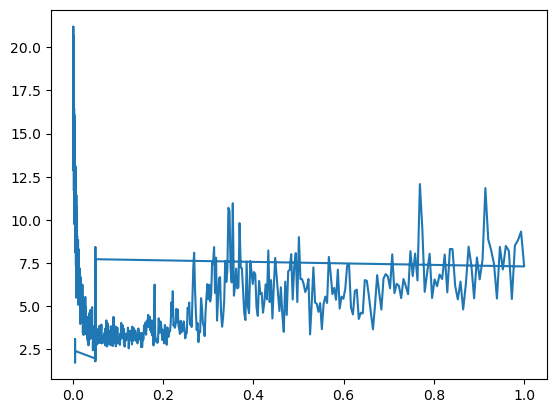

In [ ]:
plt.plot(tracker['lr'], tracker['loss'])

Text(tensor(-2.7320), tensor(2.1892), 'lr : 0.05, loss : 2.43')

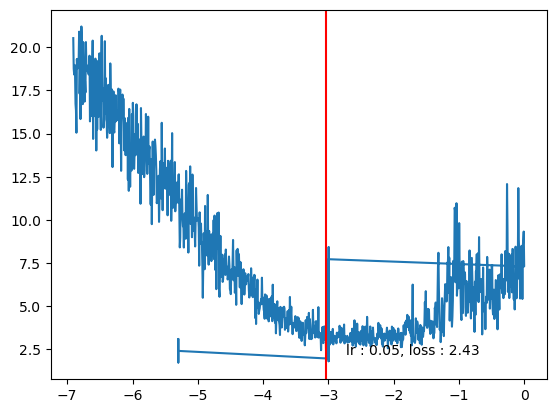

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

[<matplotlib.lines.Line2D>]

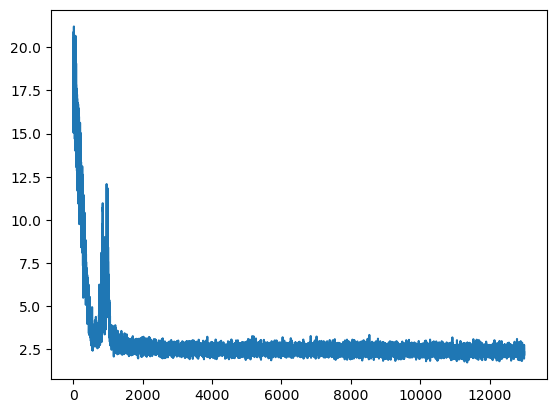

In [ ]:
plt.plot(tracker['loss'])

[<matplotlib.lines.Line2D>]

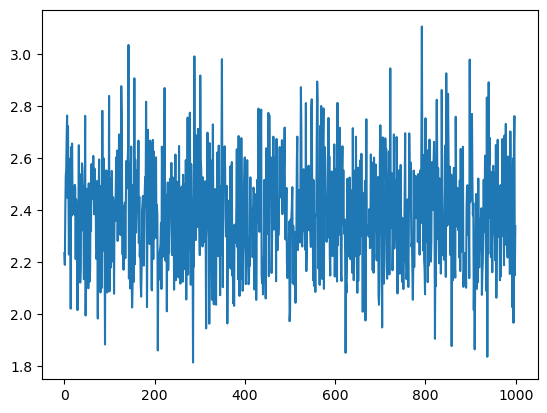

In [ ]:
plt.plot(tracker['loss'][-1000:])

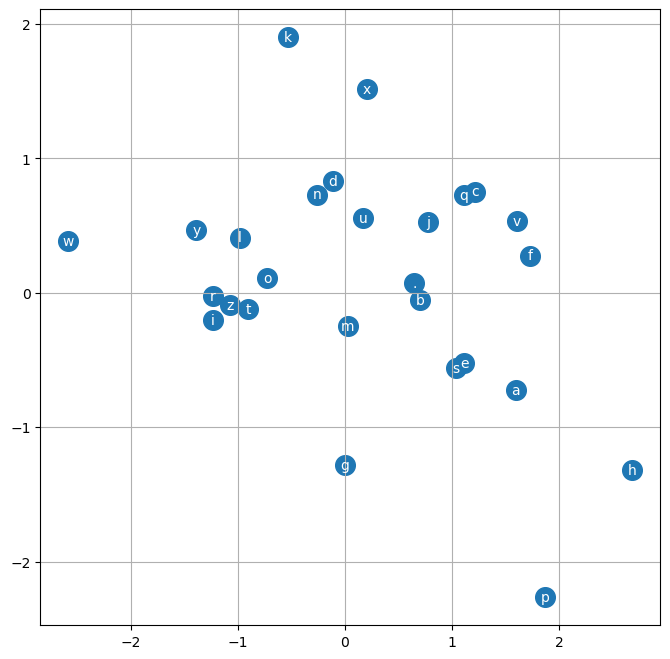

In [ ]:
plot_embeddings(model, s2i)

Some observations

- `.` is separated
- vowels are clustered together

In [ ]:
gen_word_nn(model, i2s)

['engem',
 'les',
 'lmi',
 'avay',
 'caliysoe',
 'laiten',
 'mie',
 'gariseriyen',
 'khille',
 'nbhkie',
 'mesahsammho',
 'maxem',
 'keis',
 'cren',
 'alianhh',
 'jayzeanal',
 'selanellechay',
 'raloiad',
 'yven',
 'ilasho']

## Review

### Why should you prefer `F.cross_entropy` over rolling your own implementation like `nll` above?

- Memory and by extension compute efficiency on forward pass
  When using F.cross_entropy, Pytorch doesn't create all the additional intermediate tensors for operations like exponentiation, division/ probability calculations and mean summing in memory. It will cluster up all the operations and very often will create a fused kernels, that very efficiently evaluate expression / like clustered mathematical operations

- Backward pass can be made much more efficient. Not just becoz it is a fused kernel but analytically and mathematically, it is a much more simpler pass to implement.[This is similar to manually implementing `tanh` earlier in `micrograd`]
   - We are able to reuse calculations
   - We are able to derive and simplify gradient calculations mathematically and analytics , eliminating many extra operations. With much less to implement.
   - Efficient because calculations can run in a fused kernel + expression can take a much more simpler form mathematically

- Under the hood `F.cross_entropy` can be significantly more well behaved numerically :-

In [ ]:
logits = torch.tensor([[-2, -3, 0, 5]])
counts = logits.exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs, probs.sum()
# loss = -probs[torch.arange(len(target)), target].log().mean()

(tensor([[9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01]]), tensor(1.))

Above is well behaved and we get a good probability distribution. Now consider cases where sum of these logits can take on more extreme values[ A case which can often happen during optimization of a neural network]

In [ ]:
logits = torch.tensor([[-100, -3, 0, 5]])
counts = logits.exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01]]), tensor(1.))

If some of these become extremely negative => It is still ok. We still get probabilities that are well behaved and they sum to 1.

In [ ]:
logits = torch.tensor([[-100, -3, 0, 100]])
counts = logits.exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum(), counts

(tensor([[0., 0., 0., nan]]),
 tensor(nan),
 tensor([[3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]]))

Because of the way exponentiation work. If you have very positive logits. We get not a number or `nan` because we have an `inf` in the counts because we run out of `dynamic range` in floating point number that represent these calculations. To fix this check below

- Because of the normalization in `probs` we can offset logits by any constant value and still get same results

In [ ]:
logits = torch.tensor([[-100, -3, 0, 5]])
counts = logits.exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01]]), tensor(1.))

In [ ]:
c = 4
logits = torch.tensor([[-100, -3, 0, 5]])
counts = (logits+c).exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01]]), tensor(1.))

In [ ]:
c = -4
logits = torch.tensor([[-100, -3, 0, 5]])
counts = (logits+c).exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01]]), tensor(1.))

In [ ]:
logits = torch.tensor([[-100, -3, 0, 5]])
c  = -torch.max(logits)
counts = (logits+c).exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01]]), tensor(1.))

We can do below as a fix because negative numbers are ok but positive numbers are not because they may overflow in exponentiation operation

In [ ]:
logits = torch.tensor([[-100, -3, 0, 100]])
c  = -torch.max(logits)
counts = (logits+c).exp()
probs = counts/ counts.sum(dim=1, keepdim=True); probs , probs.sum()

(tensor([[0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]]), tensor(1.))

### Why is minibatch useful? How do you do it?

- We can overfit our model with many parameters(here -> 3481) a single batch of data, say of s ize 32 like above and get a very low loss very quickly
  We can run many many examples instantly and decrease the loss much much faster.
- We randomly select some portion of the data and do forward pass, backward pass and update.
- During minibatch - quality of the gradient is lower -> it's direction is  not as reliable as calculating gradient on full dataset. But the gradient direction is good enough that it is useful.
- It is much better to take approximate gradient and make more steps than to evaluate exact gradient and make fewer steps.

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([ 29418, 217788,  87948,   2674,  30911,  38489,  91886, 112315,  46407,
        100503, 200258,  89289, 123189,   3198,  80933, 194688,  37236,  41736,
         58361, 110855,  97920,  43155, 176362, 111781,  35577, 155997, 199016,
         51131,  46479,  39425,  26168, 150284])

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([205433, 174337,  24966,  86327, 134216,  24402,  60625,  37459, 188056,
        194326,  91958, 159822, 193533,  80115,   4786,  17577, 175678,  52190,
         61067, 198309, 137570, 102400, 180954, 195297, 106963, 199382, 205548,
         35175,  19009,  22273,   3802, 177915])

### Why do we not achieve exactly zero loss in above operation with 32 size ( 5 words)?

- In examples like below  we have ... resulting in either e or i or s. Similarily mma or via or hia goes to "." . This indicates fundamental uncertainty (multiple outcomes in the training set for the same input.) in the data and therefore, loss can't be eliminated to zero(we are not able to comp. letely overfit and make the loss exactly zero). For cases where we have unique input to unique output we are getting very close to zero.



In [ ]:
X_sub, Y_sub = build_XY(words[:5], s2i, block_size=3, verbose=True)
X_sub.shape, X_sub.dtype, Y_sub.shape, Y_sub.dtype

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

999 tensor(0.2561, grad_fn=<NllLossBackward0>)


<__main__.Model>

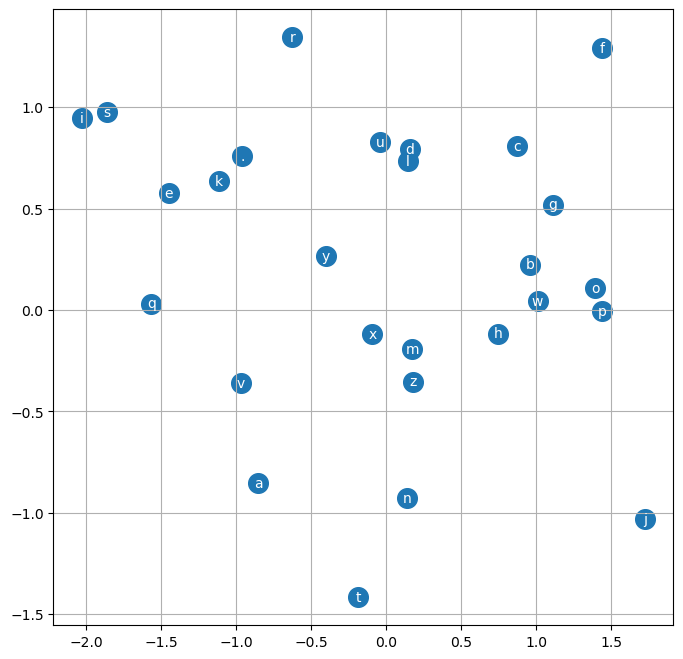

In [ ]:
model_sub = Model(len(s2i))
plot_embeddings(model_sub, s2i)
train(model_sub, X_sub, Y_sub)

In [ ]:
logits = model_sub(X_sub)
logits.max(1)

torch.return_types.max(
values=tensor([ 8.8890, 15.0034, 14.1475, 16.4668, 17.5133,  8.8890, 13.0042, 17.1599,
        22.3864, 12.0286, 17.3560, 14.6342,  8.8890, 15.7620, 16.7767, 19.9523,
         8.8890, 16.0569, 13.5875, 17.6862, 12.0533, 13.1167, 17.7194, 16.4584,
        18.3450,  8.8890, 15.7595, 12.4653, 14.3792, 22.8371, 19.5576, 15.8851],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0, 15, 19,
         1,  2,  5, 12, 12,  1,  0, 15, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y_sub

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

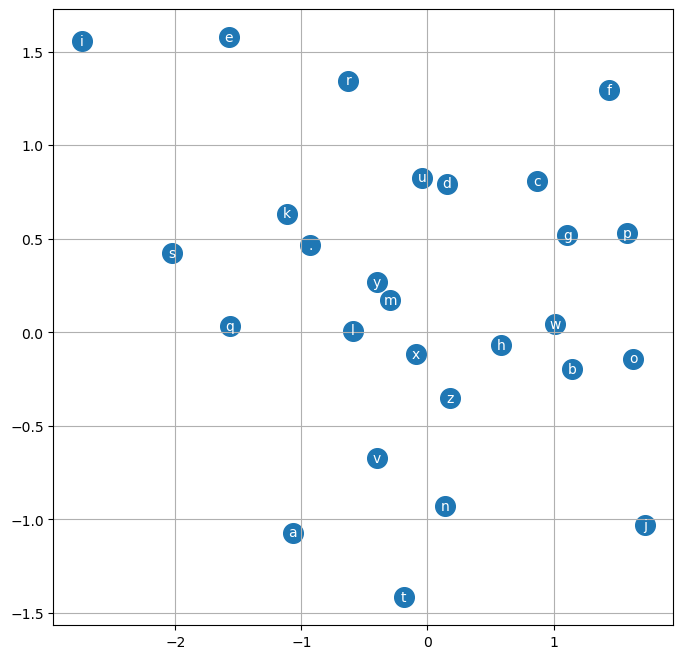

In [ ]:
plot_embeddings(model_sub, s2i)

### Why do we need to split dataset?

- As capacity of the neural network grows from 1000 - 10K to 100K parameters it becomes more and more capable of matching your dataset. Loss on training set will become very very low but it only means model is become more and more capable of memorizing your data.

- When you take such model(overfitted) and try to sample from it , you will only get example of names which are exactly like the once in training set. It will not generate new examples of name. Loss of such model on unseen data can be very high.

- We usually split the dataset into 3 splits
  - Training Split (~80% here)
  - Dev/ Validation Split (~10% here) - Development for all the hyperparameters of the model(e.g. - Size of hidden layer, size of embeddings, Strength of the regularization)
  - Test/ Blind Split(~10% here) - Performance of the model at the end. We are only evaluating loss on Test set very very sparingly.

In [ ]:
X, Y = build_XY(words, s2i, block_size=3)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
n1 = int(0.8*len(X))
n2 = int(0.9*len(X))

Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xte, Yte = X[n2:], Y[n2:]

In [ ]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182516, 3]), torch.Size([22815, 3]), torch.Size([22815, 3]))

tensor(16.8073, grad_fn=<NllLossBackward0>)

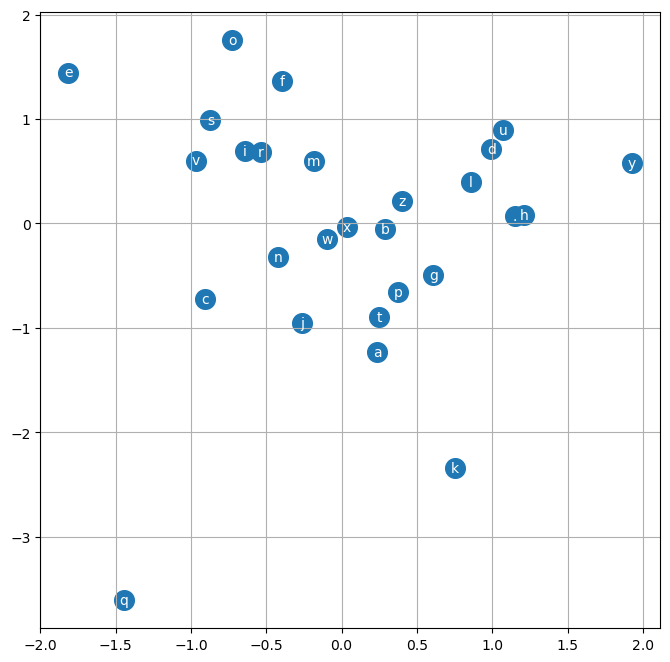

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i))
plot_embeddings(model, s2i); F.cross_entropy(model(X), Y) 

In [ ]:
train(model, Xtr, Ytr, lr=1, epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(15.8100, grad_fn=<NllLossBackward0>)
100 tensor(5.0826, grad_fn=<NllLossBackward0>)
200 tensor(6.5589, grad_fn=<NllLossBackward0>)
300 tensor(7.4009, grad_fn=<NllLossBackward0>)
400 tensor(3.6053, grad_fn=<NllLossBackward0>)
500 tensor(4.3987, grad_fn=<NllLossBackward0>)
600 tensor(3.9632, grad_fn=<NllLossBackward0>)
700 tensor(4.5862, grad_fn=<NllLossBackward0>)
800 tensor(5.1175, grad_fn=<NllLossBackward0>)
900 tensor(4.5446, grad_fn=<NllLossBackward0>)
999 tensor(3.0278, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.001, epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(3.0423, grad_fn=<NllLossBackward0>)
100 tensor(2.7571, grad_fn=<NllLossBackward0>)
200 tensor(3.2970, grad_fn=<NllLossBackward0>)
300 tensor(3.1602, grad_fn=<NllLossBackward0>)
400 tensor(3.0920, grad_fn=<NllLossBackward0>)
500 tensor(2.7909, grad_fn=<NllLossBackward0>)
600 tensor(3.0061, grad_fn=<NllLossBackward0>)
700 tensor(2.8765, grad_fn=<NllLossBackward0>)
800 tensor(3.0454, grad_fn=<NllLossBackward0>)
900 tensor(3.0402, grad_fn=<NllLossBackward0>)
999 tensor(2.7558, grad_fn=<NllLossBackward0>)


<__main__.Model>

tensor(16.4552, grad_fn=<NllLossBackward0>)

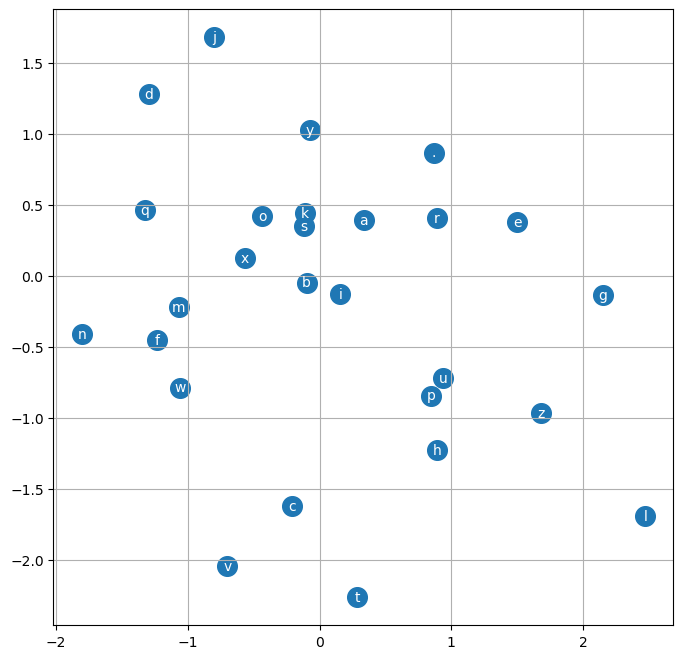

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i))
plot_embeddings(model, s2i); F.cross_entropy(model(X), Y) 

In [ ]:
train(model, Xtr, Ytr, lr=lr_scheduler(steps=1000), epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(17.6297, grad_fn=<NllLossBackward0>)
100 tensor(16.3774, grad_fn=<NllLossBackward0>)
200 tensor(11.9241, grad_fn=<NllLossBackward0>)
300 tensor(9.8699, grad_fn=<NllLossBackward0>)
400 tensor(6.3115, grad_fn=<NllLossBackward0>)
500 tensor(4.4366, grad_fn=<NllLossBackward0>)
600 tensor(3.4436, grad_fn=<NllLossBackward0>)
700 tensor(3.6737, grad_fn=<NllLossBackward0>)
800 tensor(2.9998, grad_fn=<NllLossBackward0>)
900 tensor(4.9847, grad_fn=<NllLossBackward0>)
999 tensor(10.1631, grad_fn=<NllLossBackward0>)


<__main__.Model>

Text(tensor(-1.7114), tensor(2.3272), 'lr : 0.15, loss : 2.59')

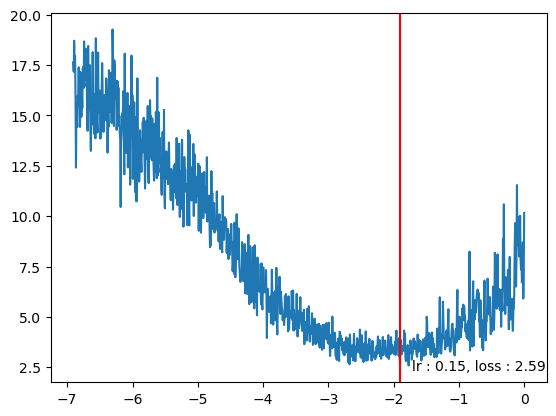

In [ ]:
# plt.plot(torch.tensor(tracker['lr']).log(), tracker['loss'])

lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
min_idx = losses.min(dim=0).indices.item()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

[<matplotlib.lines.Line2D>]

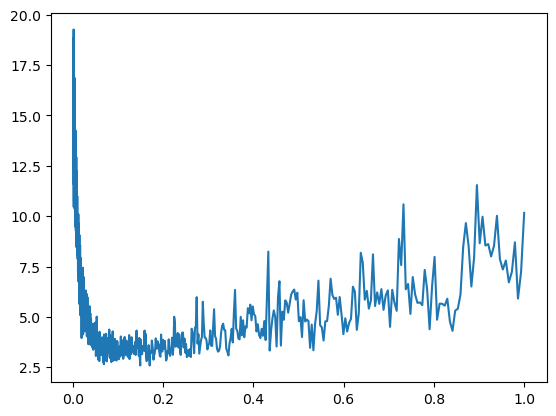

In [ ]:
plt.plot(tracker['lr'], tracker['loss'])

In [ ]:
min_idx = torch.tensor(tracker['loss']).min(dim=0).indices.item()
tracker['lr'][min_idx]

0.14933930337429047

In [ ]:
train(model, Xtr, Ytr, lr=0.15, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(6.6876, grad_fn=<NllLossBackward0>)
100 tensor(3.4560, grad_fn=<NllLossBackward0>)
200 tensor(2.7864, grad_fn=<NllLossBackward0>)
300 tensor(2.5245, grad_fn=<NllLossBackward0>)
400 tensor(2.9045, grad_fn=<NllLossBackward0>)
500 tensor(2.5189, grad_fn=<NllLossBackward0>)
600 tensor(2.5428, grad_fn=<NllLossBackward0>)


700 tensor(2.5310, grad_fn=<NllLossBackward0>)
800 tensor(2.6385, grad_fn=<NllLossBackward0>)
900 tensor(2.2941, grad_fn=<NllLossBackward0>)
1000 tensor(2.5804, grad_fn=<NllLossBackward0>)
1100 tensor(2.3543, grad_fn=<NllLossBackward0>)
1200 tensor(2.4925, grad_fn=<NllLossBackward0>)
1300 tensor(2.0018, grad_fn=<NllLossBackward0>)
1400 tensor(1.8078, grad_fn=<NllLossBackward0>)
1500 tensor(2.3858, grad_fn=<NllLossBackward0>)
1600 tensor(2.2246, grad_fn=<NllLossBackward0>)
1700 tensor(2.6969, grad_fn=<NllLossBackward0>)
1800 tensor(2.6575, grad_fn=<NllLossBackward0>)
1900 tensor(2.5793, grad_fn=<NllLossBackward0>)
2000 tensor(2.3353, grad_fn=<NllLossBackward0>)
2100 tensor(2.4477, grad_fn=<NllLossBackward0>)
2200 tensor(2.5384, grad_fn=<NllLossBackward0>)
2300 tensor(2.5009, grad_fn=<NllLossBackward0>)
2400 tensor(2.5354, grad_fn=<NllLossBackward0>)
2500 tensor(2.5816, grad_fn=<NllLossBackward0>)
2600 tensor(2.4079, grad_fn=<NllLossBackward0>)
2700 tensor(2.6247, grad_fn=<NllLossBackwar

<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.015, epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.2572, grad_fn=<NllLossBackward0>)
100 tensor(2.9018, grad_fn=<NllLossBackward0>)
200 tensor(2.5827, grad_fn=<NllLossBackward0>)
300 tensor(2.1277, grad_fn=<NllLossBackward0>)
400 tensor(1.9535, grad_fn=<NllLossBackward0>)
500 tensor(2.6978, grad_fn=<NllLossBackward0>)
600 tensor(2.4004, grad_fn=<NllLossBackward0>)
700 tensor(2.1902, grad_fn=<NllLossBackward0>)
800 tensor(2.1744, grad_fn=<NllLossBackward0>)
900 tensor(2.3676, grad_fn=<NllLossBackward0>)
999 tensor(2.4979, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.015, epochs=100, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.4496, grad_fn=<NllLossBackward0>)
99 tensor(2.1163, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
F.cross_entropy(model(Xdev), Ydev)

tensor(2.5165, grad_fn=<NllLossBackward0>)

Some of these numbers indicate (training scores < test scores). Our model is starting to overfit. Additionally model is not fully able to capture complexity and go down further as it's a simpler model. Perhaps increasing the size of model might help

### Increasing number of neurons

(tensor(50.9851, grad_fn=<NllLossBackward0>), 34081, 1000)

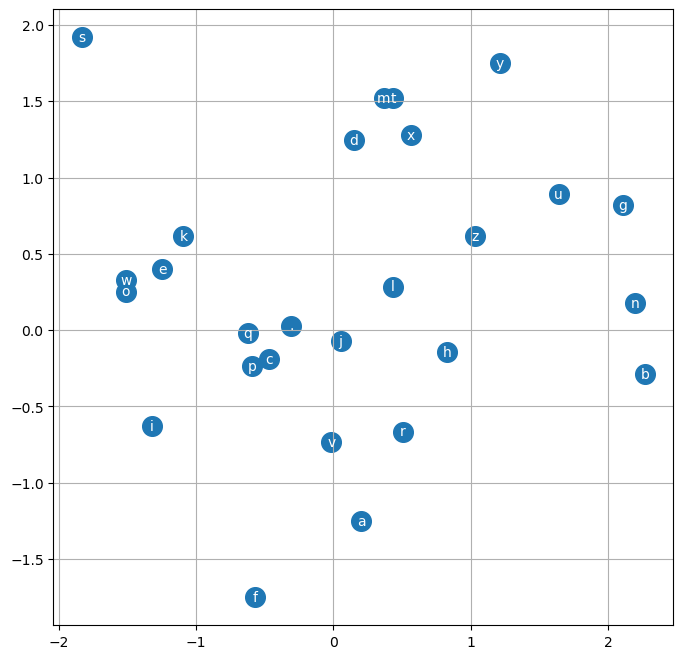

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i), hidden_units=1000)
plot_embeddings(model, s2i); F.cross_entropy(model(X), Y) , model.num_params(), model.hidden_units

In [ ]:
train(model, Xtr, Ytr, lr=lr_scheduler(steps=1000), epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(40.0518, grad_fn=<NllLossBackward0>)
100 tensor(36.5316, grad_fn=<NllLossBackward0>)
200 tensor(24.7094, grad_fn=<NllLossBackward0>)
300 tensor(16.4738, grad_fn=<NllLossBackward0>)
400 tensor(7.5011, grad_fn=<NllLossBackward0>)
500 tensor(5.0571, grad_fn=<NllLossBackward0>)
600 tensor(12.2282, grad_fn=<NllLossBackward0>)
700 tensor(11.3392, grad_fn=<NllLossBackward0>)
800 tensor(29.6099, grad_fn=<NllLossBackward0>)
900 tensor(46.9556, grad_fn=<NllLossBackward0>)
999 tensor(89.7707, grad_fn=<NllLossBackward0>)


<__main__.Model>

Text(tensor(-3.6032), tensor(2.5134), 'lr : 0.02, loss : 2.79')

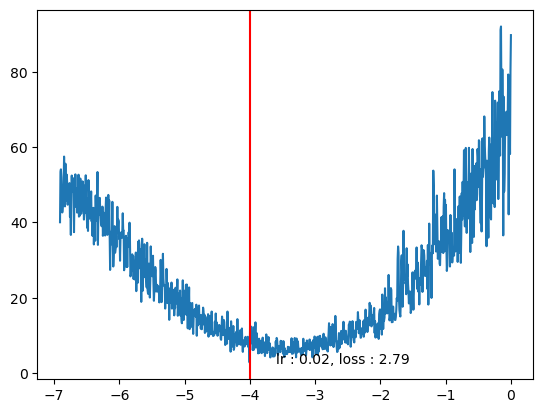

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
min_idx = losses.min(dim=0).indices.item()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

[<matplotlib.lines.Line2D>]

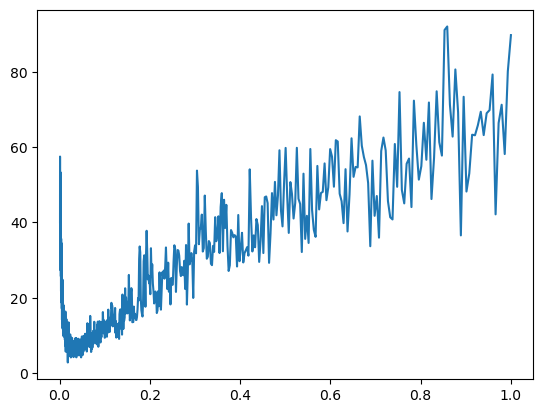

In [ ]:
plt.plot(tracker['lr'], tracker['loss'])

In [ ]:
min_idx = torch.tensor(tracker['loss']).min(dim=0).indices.item()
tracker['lr'][min_idx]

0.018249936401844025

In [ ]:
train(model, Xtr, Ytr, lr=0.02, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(61.7644, grad_fn=<NllLossBackward0>)
100 tensor(21.7138, grad_fn=<NllLossBackward0>)
200 tensor(19.0193, grad_fn=<NllLossBackward0>)
300 tensor(18.1190, grad_fn=<NllLossBackward0>)
400 tensor(7.9473, grad_fn=<NllLossBackward0>)
500 tensor(9.0366, grad_fn=<NllLossBackward0>)
600 tensor(12.0193, grad_fn=<NllLossBackward0>)
700 tensor(8.7849, grad_fn=<NllLossBackward0>)
800 tensor(6.9708, grad_fn=<NllLossBackward0>)


900 tensor(7.7025, grad_fn=<NllLossBackward0>)
1000 tensor(8.2050, grad_fn=<NllLossBackward0>)
1100 tensor(8.4025, grad_fn=<NllLossBackward0>)
1200 tensor(9.7596, grad_fn=<NllLossBackward0>)
1300 tensor(8.0802, grad_fn=<NllLossBackward0>)
1400 tensor(8.7060, grad_fn=<NllLossBackward0>)
1500 tensor(8.4114, grad_fn=<NllLossBackward0>)
1600 tensor(7.5827, grad_fn=<NllLossBackward0>)
1700 tensor(4.9879, grad_fn=<NllLossBackward0>)
1800 tensor(7.0894, grad_fn=<NllLossBackward0>)
1900 tensor(6.0056, grad_fn=<NllLossBackward0>)
2000 tensor(8.0175, grad_fn=<NllLossBackward0>)
2100 tensor(6.4426, grad_fn=<NllLossBackward0>)
2200 tensor(3.8171, grad_fn=<NllLossBackward0>)
2300 tensor(7.5533, grad_fn=<NllLossBackward0>)
2400 tensor(5.0896, grad_fn=<NllLossBackward0>)
2500 tensor(4.9172, grad_fn=<NllLossBackward0>)
2600 tensor(7.5949, grad_fn=<NllLossBackward0>)
2700 tensor(6.5752, grad_fn=<NllLossBackward0>)
2800 tensor(6.7322, grad_fn=<NllLossBackward0>)
2900 tensor(4.4214, grad_fn=<NllLossBackw

<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.001, epochs=100, batch_sz=32, verbose=True, tracker=tracker) # tried 0.02, 0.01, 0.001

0 tensor(4.8102, grad_fn=<NllLossBackward0>)
99 tensor(2.1143, grad_fn=<NllLossBackward0>)


<__main__.Model>

In [ ]:
F.cross_entropy(model(Xdev), Ydev)

tensor(4.7569, grad_fn=<NllLossBackward0>)

In [ ]:
model.num_params()

34081

(tensor(29.5214, grad_fn=<NllLossBackward0>), 10281, 300)

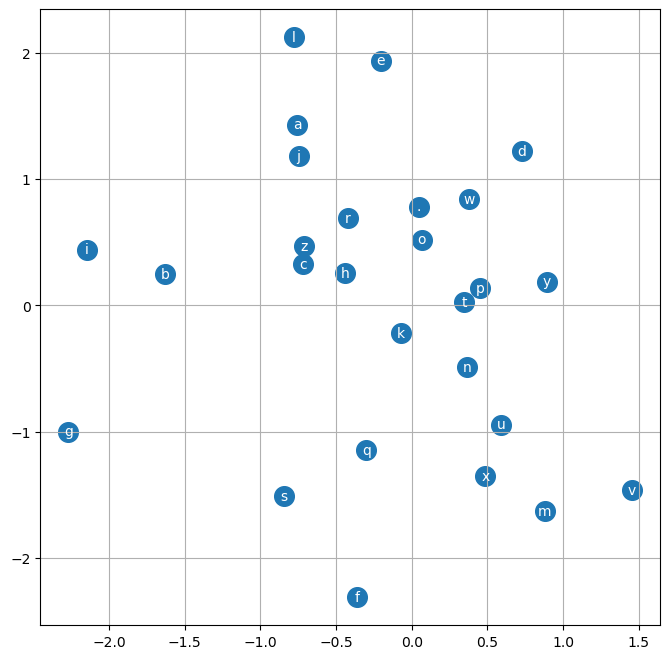

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i), hidden_units=300)
plot_embeddings(model, s2i); F.cross_entropy(model(X), Y) , model.num_params(), model.hidden_units

In [ ]:
train(model, Xtr, Ytr, lr=lr_scheduler(steps=1000), epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(37.3450, grad_fn=<NllLossBackward0>)
100 tensor(24.5692, grad_fn=<NllLossBackward0>)
200 tensor(15.8155, grad_fn=<NllLossBackward0>)
300 tensor(9.1198, grad_fn=<NllLossBackward0>)
400 tensor(4.8730, grad_fn=<NllLossBackward0>)
500 tensor(5.8543, grad_fn=<NllLossBackward0>)
600 tensor(5.2846, grad_fn=<NllLossBackward0>)
700 tensor(5.8586, grad_fn=<NllLossBackward0>)
800 tensor(9.6759, grad_fn=<NllLossBackward0>)
900 tensor(14.6072, grad_fn=<NllLossBackward0>)
999 tensor(18.3681, grad_fn=<NllLossBackward0>)


<__main__.Model>

Text(tensor(-3.3294), tensor(2.5136), 'lr : 0.02, loss : 2.79')

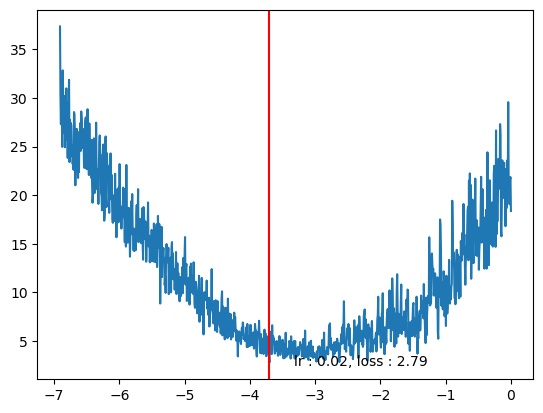

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
min_idx = losses.min(dim=0).indices.item()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

In [ ]:
train(model, Xtr, Ytr, lr=0.02, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.3650, grad_fn=<NllLossBackward0>)
100 tensor(2.5750, grad_fn=<NllLossBackward0>)
200 tensor(2.2345, grad_fn=<NllLossBackward0>)
300 tensor(2.6657, grad_fn=<NllLossBackward0>)
400 tensor(2.2304, grad_fn=<NllLossBackward0>)
500 tensor(3.2544, grad_fn=<NllLossBackward0>)
600 tensor(2.5204, grad_fn=<NllLossBackward0>)
700 tensor(2.7564, grad_fn=<NllLossBackward0>)
800 tensor(2.4260, grad_fn=<NllLossBackward0>)
900 tensor(2.9606, grad_fn=<NllLossBackward0>)
1000 tensor(2.8647, grad_fn=<NllLossBackward0>)
1100 tensor(2.7729, grad_fn=<NllLossBackward0>)
1200 tensor(2.2639, grad_fn=<NllLossBackward0>)
1300 tensor(2.4464, grad_fn=<NllLossBackward0>)
1400 tensor(2.3443, grad_fn=<NllLossBackward0>)
1500 tensor(2.8512, grad_fn=<NllLossBackward0>)
1600 tensor(2.6609, grad_fn=<NllLossBackward0>)


1700 tensor(2.9302, grad_fn=<NllLossBackward0>)
1800 tensor(2.7442, grad_fn=<NllLossBackward0>)
1900 tensor(3.3001, grad_fn=<NllLossBackward0>)
2000 tensor(2.3761, grad_fn=<NllLossBackward0>)
2100 tensor(2.6010, grad_fn=<NllLossBackward0>)
2200 tensor(2.3317, grad_fn=<NllLossBackward0>)
2300 tensor(2.3662, grad_fn=<NllLossBackward0>)
2400 tensor(2.9355, grad_fn=<NllLossBackward0>)
2500 tensor(2.5726, grad_fn=<NllLossBackward0>)
2600 tensor(2.1554, grad_fn=<NllLossBackward0>)
2700 tensor(2.4191, grad_fn=<NllLossBackward0>)
2800 tensor(2.4981, grad_fn=<NllLossBackward0>)
2900 tensor(2.4923, grad_fn=<NllLossBackward0>)
3000 tensor(2.1398, grad_fn=<NllLossBackward0>)
3100 tensor(2.4383, grad_fn=<NllLossBackward0>)
3200 tensor(2.0546, grad_fn=<NllLossBackward0>)
3300 tensor(2.2128, grad_fn=<NllLossBackward0>)
3400 tensor(2.0385, grad_fn=<NllLossBackward0>)
3500 tensor(2.3519, grad_fn=<NllLossBackward0>)
3600 tensor(2.5346, grad_fn=<NllLossBackward0>)
3700 tensor(2.3406, grad_fn=<NllLossBack

<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.002, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.5914, grad_fn=<NllLossBackward0>)
100 tensor(2.6015, grad_fn=<NllLossBackward0>)
200 tensor(2.6615, grad_fn=<NllLossBackward0>)
300 tensor(2.1866, grad_fn=<NllLossBackward0>)
400 tensor(2.4424, grad_fn=<NllLossBackward0>)
500 tensor(2.3740, grad_fn=<NllLossBackward0>)
600 tensor(2.2900, grad_fn=<NllLossBackward0>)
700 tensor(2.4071, grad_fn=<NllLossBackward0>)
800 tensor(2.3903, grad_fn=<NllLossBackward0>)
900 tensor(2.4372, grad_fn=<NllLossBackward0>)
1000 tensor(2.7021, grad_fn=<NllLossBackward0>)
1100 tensor(2.3557, grad_fn=<NllLossBackward0>)
1200 tensor(2.4595, grad_fn=<NllLossBackward0>)
1300 tensor(2.2065, grad_fn=<NllLossBackward0>)
1400 tensor(2.4413, grad_fn=<NllLossBackward0>)
1500 tensor(2.3990, grad_fn=<NllLossBackward0>)


1600 tensor(2.3373, grad_fn=<NllLossBackward0>)
1700 tensor(2.6296, grad_fn=<NllLossBackward0>)
1800 tensor(2.5524, grad_fn=<NllLossBackward0>)
1900 tensor(2.4687, grad_fn=<NllLossBackward0>)
2000 tensor(2.2817, grad_fn=<NllLossBackward0>)
2100 tensor(2.3427, grad_fn=<NllLossBackward0>)
2200 tensor(2.3225, grad_fn=<NllLossBackward0>)
2300 tensor(2.3668, grad_fn=<NllLossBackward0>)
2400 tensor(2.3957, grad_fn=<NllLossBackward0>)
2500 tensor(2.4984, grad_fn=<NllLossBackward0>)
2600 tensor(2.4131, grad_fn=<NllLossBackward0>)
2700 tensor(2.1443, grad_fn=<NllLossBackward0>)
2800 tensor(2.4484, grad_fn=<NllLossBackward0>)
2900 tensor(2.5513, grad_fn=<NllLossBackward0>)
3000 tensor(2.1167, grad_fn=<NllLossBackward0>)
3100 tensor(2.5792, grad_fn=<NllLossBackward0>)
3200 tensor(2.3018, grad_fn=<NllLossBackward0>)
3300 tensor(2.2011, grad_fn=<NllLossBackward0>)
3400 tensor(3.1988, grad_fn=<NllLossBackward0>)
3500 tensor(2.6448, grad_fn=<NllLossBackward0>)
3600 tensor(2.6687, grad_fn=<NllLossBack

<__main__.Model>

In [ ]:
F.cross_entropy(model(Xdev), Ydev)

tensor(2.6687, grad_fn=<NllLossBackward0>)

### Increasing Embedding size

- We might want to keep parameters close to ~10K

/opt/homebrew/Caskroom/miniforge/base/envs/aiking/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(tensor(24.9783, grad_fn=<NllLossBackward0>), 11897, 200)

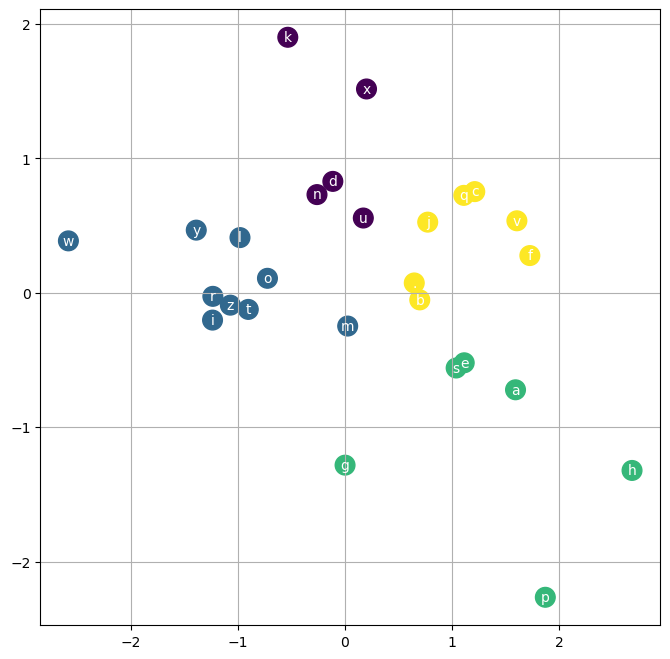

In [ ]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }
model = Model(len(s2i), hidden_units=200, emb_sz=10)
plot_embeddings(model, s2i, emb_model = TSNE(random_state=0, n_iter=1000, perplexity=26), cluster_model=KMeans(n_clusters=4) ); F.cross_entropy(model(X), Y) , model.num_params(), model.hidden_units

In [ ]:
train(model, Xtr, Ytr, lr=lr_scheduler(steps=1000), epochs=1000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(23.6677, grad_fn=<NllLossBackward0>)
100 tensor(15.7213, grad_fn=<NllLossBackward0>)
200 tensor(17.7044, grad_fn=<NllLossBackward0>)
300 tensor(15.3154, grad_fn=<NllLossBackward0>)
400 tensor(11.2020, grad_fn=<NllLossBackward0>)
500 tensor(13.0558, grad_fn=<NllLossBackward0>)
600 tensor(6.7073, grad_fn=<NllLossBackward0>)
700 tensor(7.7102, grad_fn=<NllLossBackward0>)
800 tensor(10.5667, grad_fn=<NllLossBackward0>)
900 tensor(10.3973, grad_fn=<NllLossBackward0>)
999 tensor(14.0128, grad_fn=<NllLossBackward0>)


<__main__.Model>

Text(tensor(-2.0163), tensor(3.5029), 'lr : 0.11, loss : 3.89')

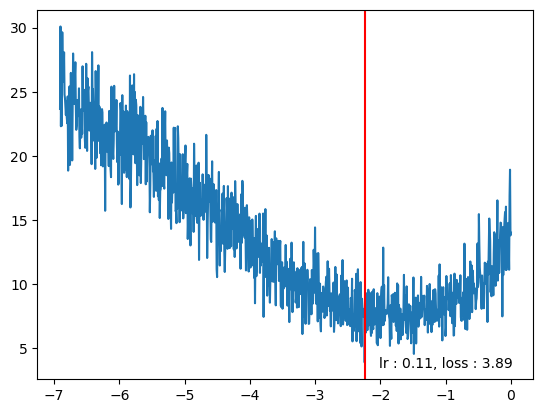

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
min_idx = losses.min(dim=0).indices.item()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

In [ ]:
train(model, Xtr, Ytr, lr=0.11, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(16.1025, grad_fn=<NllLossBackward0>)
100 tensor(4.2531, grad_fn=<NllLossBackward0>)
200 tensor(3.6509, grad_fn=<NllLossBackward0>)
300 tensor(5.5972, grad_fn=<NllLossBackward0>)
400 tensor(3.5624, grad_fn=<NllLossBackward0>)
500 tensor(3.7660, grad_fn=<NllLossBackward0>)
600 tensor(4.1625, grad_fn=<NllLossBackward0>)
700 tensor(3.8562, grad_fn=<NllLossBackward0>)
800 tensor(2.3530, grad_fn=<NllLossBackward0>)
900 tensor(3.7563, grad_fn=<NllLossBackward0>)
1000 tensor(4.1694, grad_fn=<NllLossBackward0>)
1100 tensor(3.5898, grad_fn=<NllLossBackward0>)
1200 tensor(3.3913, grad_fn=<NllLossBackward0>)
1300 tensor(3.1442, grad_fn=<NllLossBackward0>)
1400 tensor(2.4846, grad_fn=<NllLossBackward0>)
1500 tensor(3.7013, grad_fn=<NllLossBackward0>)
1600 tensor(3.6672, grad_fn=<NllLossBackward0>)
1700 tensor(3.1273, grad_fn=<NllLossBackward0>)
1800 tensor(2.4491, grad_fn=<NllLossBackward0>)
1900 tensor(3.5135, grad_fn=<NllLossBackward0>)
2000 tensor(3.2433, grad_fn=<NllLossBackward0>)
210

2400 tensor(2.5878, grad_fn=<NllLossBackward0>)
2500 tensor(2.5127, grad_fn=<NllLossBackward0>)
2600 tensor(2.6652, grad_fn=<NllLossBackward0>)
2700 tensor(2.3650, grad_fn=<NllLossBackward0>)
2800 tensor(3.1310, grad_fn=<NllLossBackward0>)
2900 tensor(3.1550, grad_fn=<NllLossBackward0>)
3000 tensor(3.3197, grad_fn=<NllLossBackward0>)
3100 tensor(2.4888, grad_fn=<NllLossBackward0>)
3200 tensor(3.0126, grad_fn=<NllLossBackward0>)
3300 tensor(3.4476, grad_fn=<NllLossBackward0>)
3400 tensor(2.4726, grad_fn=<NllLossBackward0>)
3500 tensor(2.4124, grad_fn=<NllLossBackward0>)
3600 tensor(2.2420, grad_fn=<NllLossBackward0>)
3700 tensor(2.1160, grad_fn=<NllLossBackward0>)
3800 tensor(2.7342, grad_fn=<NllLossBackward0>)
3900 tensor(2.7886, grad_fn=<NllLossBackward0>)
4000 tensor(2.7494, grad_fn=<NllLossBackward0>)
4100 tensor(2.4470, grad_fn=<NllLossBackward0>)
4200 tensor(3.0389, grad_fn=<NllLossBackward0>)
4300 tensor(2.5901, grad_fn=<NllLossBackward0>)
4400 tensor(2.6222, grad_fn=<NllLossBack

<__main__.Model>

In [ ]:
train(model, Xtr, Ytr, lr=0.011, epochs=10000, batch_sz=32, verbose=True, tracker=tracker)

0 tensor(2.4361, grad_fn=<NllLossBackward0>)
100 tensor(2.5009, grad_fn=<NllLossBackward0>)
200 tensor(1.6655, grad_fn=<NllLossBackward0>)
300 tensor(1.7574, grad_fn=<NllLossBackward0>)
400 tensor(2.5683, grad_fn=<NllLossBackward0>)
500 tensor(1.8705, grad_fn=<NllLossBackward0>)
600 tensor(2.2056, grad_fn=<NllLossBackward0>)
700 tensor(1.9754, grad_fn=<NllLossBackward0>)
800 tensor(1.9142, grad_fn=<NllLossBackward0>)
900 tensor(2.0410, grad_fn=<NllLossBackward0>)
1000 tensor(2.1931, grad_fn=<NllLossBackward0>)
1100 tensor(2.0752, grad_fn=<NllLossBackward0>)
1200 tensor(2.0992, grad_fn=<NllLossBackward0>)
1300 tensor(2.6865, grad_fn=<NllLossBackward0>)
1400 tensor(2.5488, grad_fn=<NllLossBackward0>)
1500 tensor(1.9268, grad_fn=<NllLossBackward0>)
1600 tensor(1.7528, grad_fn=<NllLossBackward0>)
1700 tensor(2.1228, grad_fn=<NllLossBackward0>)
1800 tensor(2.3399, grad_fn=<NllLossBackward0>)
1900 tensor(2.0663, grad_fn=<NllLossBackward0>)
2000 tensor(2.2824, grad_fn=<NllLossBackward0>)
2100

2400 tensor(2.2795, grad_fn=<NllLossBackward0>)
2500 tensor(1.7492, grad_fn=<NllLossBackward0>)
2600 tensor(2.3349, grad_fn=<NllLossBackward0>)
2700 tensor(1.9319, grad_fn=<NllLossBackward0>)
2800 tensor(2.3628, grad_fn=<NllLossBackward0>)
2900 tensor(2.6416, grad_fn=<NllLossBackward0>)
3000 tensor(3.0241, grad_fn=<NllLossBackward0>)
3100 tensor(2.1092, grad_fn=<NllLossBackward0>)
3200 tensor(2.3266, grad_fn=<NllLossBackward0>)
3300 tensor(2.3129, grad_fn=<NllLossBackward0>)
3400 tensor(2.3494, grad_fn=<NllLossBackward0>)
3500 tensor(2.4274, grad_fn=<NllLossBackward0>)
3600 tensor(2.3356, grad_fn=<NllLossBackward0>)
3700 tensor(3.1555, grad_fn=<NllLossBackward0>)
3800 tensor(2.6469, grad_fn=<NllLossBackward0>)
3900 tensor(2.1959, grad_fn=<NllLossBackward0>)
4000 tensor(2.4170, grad_fn=<NllLossBackward0>)
4100 tensor(2.1809, grad_fn=<NllLossBackward0>)
4200 tensor(1.6268, grad_fn=<NllLossBackward0>)
4300 tensor(2.0488, grad_fn=<NllLossBackward0>)
4400 tensor(2.1533, grad_fn=<NllLossBack

<__main__.Model>

In [ ]:
F.cross_entropy(model(Xdev), Ydev)

tensor(2.5698, grad_fn=<NllLossBackward0>)

In [ ]:
model.C.shape

torch.Size([27, 10])

In [ ]:
emb_model = TSNE(random_state=0, n_iter=1000, perplexity=26)
# emb_model.fit_transform(model.C.item())
# emb_model.fit_transform(model.C.detach().numpy())

/opt/homebrew/Caskroom/miniforge/base/envs/aiking/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(tensor(2.3051, grad_fn=<NllLossBackward0>), 11897, 200)

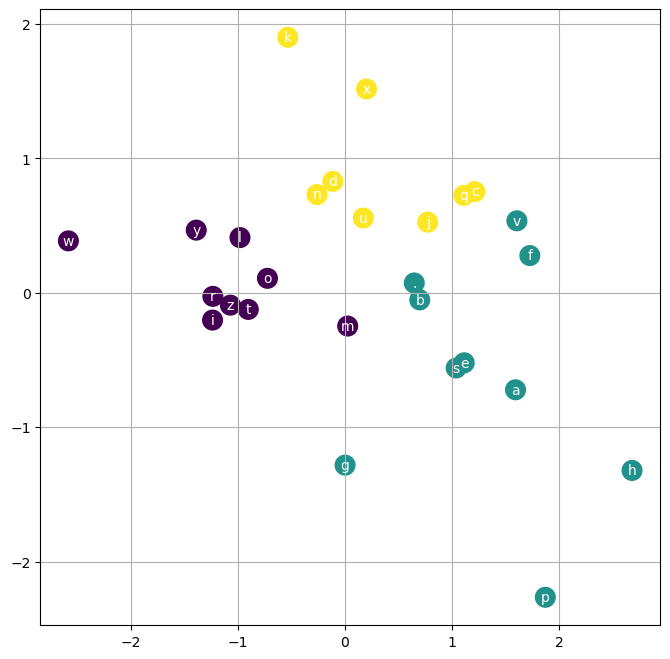

In [ ]:
plot_embeddings(model, s2i, emb_model = emb_model, cluster_model=KMeans(n_clusters=3)), ; F.cross_entropy(model(X), Y) , model.num_params(), model.hidden_units

[<matplotlib.lines.Line2D>]

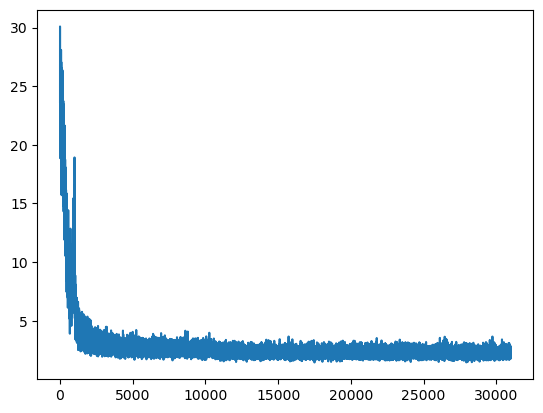

In [ ]:
plt.plot(tracker['loss'])

Text(tensor(-4.0589), tensor(1.2932), 'lr : 0.01, loss : 1.44')

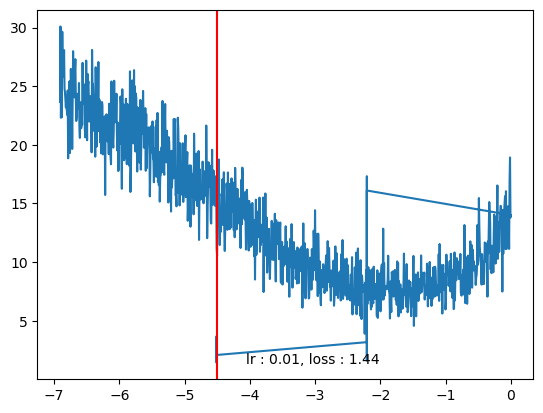

In [ ]:
lrs = torch.tensor(tracker['lr'])
losses = torch.tensor(tracker['loss'])
log_lrs = lrs.log()
min_idx = losses.min(dim=0).indices.item()
plt.plot(log_lrs, tracker['loss'])
plt.axvline(log_lrs[min_idx], color='r')
plt.text(log_lrs[min_idx]*0.9,losses[min_idx]*0.9, f"lr : {lrs[min_idx].item():0.2f}, loss : {losses[min_idx].item():0.2f}") 

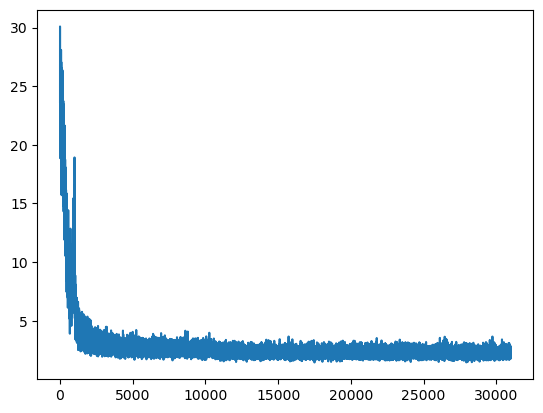

In [ ]:
ax = plt.plot(tracker['loss'])

[<matplotlib.lines.Line2D>]

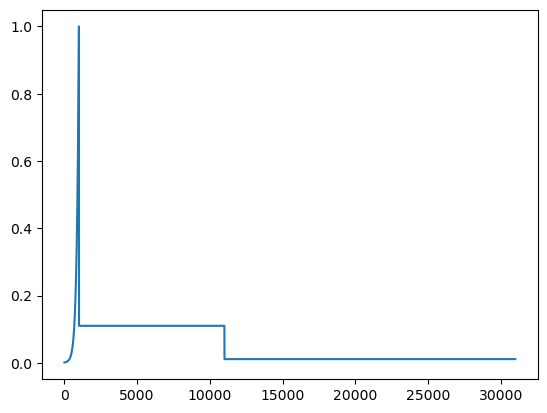

In [ ]:
 plt.plot(tracker['lr'])

### Additional Hyperparameter Tuning

- Batch size is so low we have , that we have way too much noise in the training --> increase batch size , so we have correct gradient and we are not jumping up and down on the gradient. And we can optimize more properly

- ~~May be our embedding size if low . We are cramming way too much neurons in 2 dimension and neural network is not able to use the space effectively~~

## Todo

- Additional hyperparameter tuning - "check for better convergence with batch size changes", increasing embedding size
- Notes on last few minutes of video
- ~~`F.softmax` in word generation~~

In [623]:
#| hide
import nbdev; nbdev.nbdev_export()